# Training

In [2]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def preprocess(data):
    a = data
    m, std = np.mean(a[:, :, 0]), np.std(a[:, :, 0])
    a[:, :, 0] = (a[:, :, 0] - m) / std 
    m, std = np.mean(a[:, :, 1]), np.std(a[:, :, 1])
    a[:, :, 1] = (a[:, :, 1] - m) / std 
    m, std = np.mean(a[:, :, 2]), np.std(a[:, :, 2])
    a[:, :, 2] = (a[:, :, 2] - m) / std 
    m, std = np.mean(a[:, :, 3]), np.std(a[:, :, 3])
    a[:, :, 3] = (a[:, :, 3] - m) / std 
    return a

In [4]:
# define the hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
n_cells = 576
n_indicators = 4
input_size = n_cells, n_indicators
hidden_size = 64
learning_rate = 0.001
num_epochs = 3
batch_size = 16
seq_len = 1000
val_seq_len = 500
num_layers = 2

cuda


In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, val_seq_len):
        data = preprocess(data)  # shape (time_seq, N, U)
        self.seq_len = seq_len
        self.val_seq_len = val_seq_len
        self.data = torch.from_numpy(data).float()

    def __len__(self):
        return self.data.shape[0] - self.val_seq_len - self.seq_len - 1

    def __getitem__(self, i):
        return self.data[i: i+self.seq_len], self.data[i+1: i+1+self.seq_len], \
            self.data[i+1+self.seq_len: i+1+self.seq_len+self.val_seq_len], self.data[i+2+self.seq_len: i+2+self.seq_len+self.val_seq_len]

# Load the data   
import numpy.random as npr
with open('X_400_109_ori.pickle', 'rb') as handle:
    data = pickle.load(handle)

# Define the training and test sets
train_size = int(data.shape[0] * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Create dataloaders for the training and test sets
train_dataset = TimeSeriesDataset(train_data, seq_len, val_seq_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataset), len(test_data))

42339 10961


In [6]:
X, y, X_val, y_val = next(iter(train_loader))
print(X.shape, y.shape, X_val.shape, y_val.shape)

torch.Size([16, 1000, 576, 4]) torch.Size([16, 1000, 576, 4]) torch.Size([16, 500, 576, 4]) torch.Size([16, 500, 576, 4])


In [7]:
# define the autoregressive forecasting model
class LSTM(nn.Module):
    def __init__(self, num_input_features, hidden_layer_size, num_layers):
        super().__init__()
        input_size = num_input_features[0] * num_input_features[1]
        
        self.num_layer = num_layers
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_layer_size, input_size)
        self.hidden_cell = None

    def forward(self, x):
        batch_size, seq_len, height, width = x.size()
        x = x.view(batch_size, seq_len, height*width)
        lstm_out, self.hidden_cell = self.lstm(x, self.hidden_cell)
        preds = []
        for t in range(seq_len):
            pred = self.fc(lstm_out[:, t, :])
            pred = pred.view(batch_size, 1, height, width)
            preds.append(pred)
        out = torch.cat(preds, axis=1)
        return out

In [8]:
def validation(b_, data_val, future):
    preds = []
    model.hidden_cell = (torch.zeros(num_layers, b_, model.hidden_layer_size).to(device),
                    torch.zeros(num_layers, b_, model.hidden_layer_size).to(device))
    output = model(data_val)
    inpt = output[:, -1, :, :].unsqueeze(1)

    for i in range(future):
        output = model(inpt)
        preds.append(output)
        inpt = output
    preds = torch.cat(preds, axis=1)
    
    return preds


In [8]:
import time
start_time = time.time()

# Create model, optimizer, loss function, and move to device
model = LSTM(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.6)
criterion = nn.MSELoss()
model.to(device)


# Train model
min_loss0 = 10000
min_loss1 = 10000
loss_save = []
for epoch in range(num_epochs):
    running_loss = 0.0
    bi = 0
    for data, target, data_val, target_val in train_loader:
        model.train()  # Optional when not using Model Specific layer
        
        # Move input to device
        b_, _, _, _ = data.size()
        data = data.to(device)
        target = target.to(device)
        data_val = data_val.to(device)
        target_val = target_val.to(device)

        # Zero gradients, forward pass, backward pass, and update parameters
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(num_layers, b_, model.hidden_layer_size).to(device),
                            torch.zeros(num_layers, b_, model.hidden_layer_size).to(device))
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()     # Optional when not using Model Specific layer
        with torch.no_grad():
            target = validation(b_, data_val, val_seq_len)
            valid_loss = criterion(target, target_val)
        

        running_loss += loss.item()
        print(f"Epoch {epoch+1}, Batch {bi}: Loss {loss.item()}, Validation {valid_loss.item()}")
        loss_save.append((loss.item(), valid_loss.item()))
        
        bi += 1
        if valid_loss.item() < min_loss0:
            min_loss0 = valid_loss.item()
            print("min_val_loss", min_loss0)
            torch.save(model.state_dict(), f"lstm-minvalloss-{epoch}-{bi}.pt")
        
        if loss.item() < min_loss1:
            min_loss1 = loss.item()
            print("min_loss", min_loss1)
            torch.save(model.state_dict(), f"lstm_ar-minloss-{epoch}-{bi}.pt")
    
    scheduler.step()
    print('\tEpoch %d: loss=%0.5f' % (epoch+1, running_loss / len(train_loader)))
    torch.save(model.state_dict(), f"0410/lstm_seq{seq_len}_ep{epoch}.pt")
    
    
end_time = time.time()

total_time = end_time - start_time
print(f"Total running time: {total_time} seconds.")

Epoch 1, Batch 0: Loss 0.9970577359199524, Validation 0.994044303894043
min_val_loss 0.994044303894043
min_loss 0.9970577359199524
Epoch 1, Batch 1: Loss 0.9953134655952454, Validation 1.0001294612884521
min_loss 0.9953134655952454
Epoch 1, Batch 2: Loss 1.008194923400879, Validation 1.0222889184951782
Epoch 1, Batch 3: Loss 0.9924589991569519, Validation 1.015761137008667
min_loss 0.9924589991569519
Epoch 1, Batch 4: Loss 0.9782831072807312, Validation 1.0133297443389893
min_loss 0.9782831072807312
Epoch 1, Batch 5: Loss 0.9607722759246826, Validation 1.0092484951019287
min_loss 0.9607722759246826
Epoch 1, Batch 6: Loss 0.9360193014144897, Validation 0.9998596906661987
min_loss 0.9360193014144897
Epoch 1, Batch 7: Loss 0.9277294874191284, Validation 1.0096818208694458
min_loss 0.9277294874191284
Epoch 1, Batch 8: Loss 0.8933981657028198, Validation 0.9960597157478333
min_loss 0.8933981657028198
Epoch 1, Batch 9: Loss 0.8794536590576172, Validation 1.0149221420288086
min_loss 0.8794536

Epoch 1, Batch 83: Loss 0.13402581214904785, Validation 1.9087949991226196
min_loss 0.13402581214904785
Epoch 1, Batch 84: Loss 0.13405419886112213, Validation 1.8807244300842285
Epoch 1, Batch 85: Loss 0.13003236055374146, Validation 1.7823307514190674
min_loss 0.13003236055374146
Epoch 1, Batch 86: Loss 0.12808798253536224, Validation 1.8930658102035522
min_loss 0.12808798253536224
Epoch 1, Batch 87: Loss 0.12893545627593994, Validation 1.866439700126648
Epoch 1, Batch 88: Loss 0.13089130818843842, Validation 1.779359221458435
Epoch 1, Batch 89: Loss 0.12216880917549133, Validation 1.8081258535385132
min_loss 0.12216880917549133
Epoch 1, Batch 90: Loss 0.1189735010266304, Validation 1.8072081804275513
min_loss 0.1189735010266304
Epoch 1, Batch 91: Loss 0.12192179262638092, Validation 1.8332794904708862
Epoch 1, Batch 92: Loss 0.11866003274917603, Validation 1.9238770008087158
min_loss 0.11866003274917603
Epoch 1, Batch 93: Loss 0.1156725138425827, Validation 1.8746322393417358
min_lo

Epoch 1, Batch 178: Loss 0.05556917563080788, Validation 1.7273496389389038
min_loss 0.05556917563080788
Epoch 1, Batch 179: Loss 0.05641227215528488, Validation 1.2124906778335571
Epoch 1, Batch 180: Loss 0.056693971157073975, Validation 1.71351957321167
Epoch 1, Batch 181: Loss 0.05317477881908417, Validation 1.5542352199554443
min_loss 0.05317477881908417
Epoch 1, Batch 182: Loss 0.0589790977537632, Validation 1.5727794170379639
Epoch 1, Batch 183: Loss 0.054486483335494995, Validation 1.2972908020019531
Epoch 1, Batch 184: Loss 0.05320556089282036, Validation 1.3892284631729126
Epoch 1, Batch 185: Loss 0.056076571345329285, Validation 1.6967285871505737
Epoch 1, Batch 186: Loss 0.05407216399908066, Validation 1.5835399627685547
Epoch 1, Batch 187: Loss 0.056337639689445496, Validation 1.3176610469818115
Epoch 1, Batch 188: Loss 0.05612383037805557, Validation 1.3180160522460938
Epoch 1, Batch 189: Loss 0.05303136631846428, Validation 1.5655436515808105
min_loss 0.05303136631846428


Epoch 1, Batch 278: Loss 0.041821595281362534, Validation 1.5913090705871582
Epoch 1, Batch 279: Loss 0.0409066304564476, Validation 1.4806054830551147
Epoch 1, Batch 280: Loss 0.03759944811463356, Validation 1.55404794216156
Epoch 1, Batch 281: Loss 0.03826488181948662, Validation 1.3278803825378418
Epoch 1, Batch 282: Loss 0.0352986641228199, Validation 1.4574130773544312
min_loss 0.0352986641228199
Epoch 1, Batch 283: Loss 0.045319363474845886, Validation 1.2807133197784424
Epoch 1, Batch 284: Loss 0.03789224475622177, Validation 1.606786847114563
Epoch 1, Batch 285: Loss 0.04339637607336044, Validation 1.4842065572738647
Epoch 1, Batch 286: Loss 0.038548994809389114, Validation 1.6001660823822021
Epoch 1, Batch 287: Loss 0.036582592874765396, Validation 1.592169165611267
Epoch 1, Batch 288: Loss 0.03861850127577782, Validation 1.335750937461853
Epoch 1, Batch 289: Loss 0.03801397979259491, Validation 1.4386478662490845
Epoch 1, Batch 290: Loss 0.038312576711177826, Validation 1.518

Epoch 1, Batch 383: Loss 0.0297867301851511, Validation 1.1283769607543945
Epoch 1, Batch 384: Loss 0.03266556188464165, Validation 1.5566868782043457
Epoch 1, Batch 385: Loss 0.02987024374306202, Validation 1.5835731029510498
Epoch 1, Batch 386: Loss 0.0328180156648159, Validation 1.5963630676269531
Epoch 1, Batch 387: Loss 0.030208421871066093, Validation 1.1744494438171387
Epoch 1, Batch 388: Loss 0.02754891850054264, Validation 1.5477890968322754
min_loss 0.02754891850054264
Epoch 1, Batch 389: Loss 0.028479380533099174, Validation 1.207818627357483
Epoch 1, Batch 390: Loss 0.029319994151592255, Validation 2.2804832458496094
Epoch 1, Batch 391: Loss 0.02843387797474861, Validation 1.3647942543029785
Epoch 1, Batch 392: Loss 0.029696980491280556, Validation 1.482394814491272
Epoch 1, Batch 393: Loss 0.02877093479037285, Validation 1.4902677536010742
Epoch 1, Batch 394: Loss 0.032859161496162415, Validation 1.6006855964660645
Epoch 1, Batch 395: Loss 0.031214646995067596, Validation 

Epoch 1, Batch 487: Loss 0.025029748678207397, Validation 1.3124418258666992
Epoch 1, Batch 488: Loss 0.025271935388445854, Validation 2.5279788970947266
Epoch 1, Batch 489: Loss 0.021629810333251953, Validation 1.1280877590179443
min_loss 0.021629810333251953
Epoch 1, Batch 490: Loss 0.025098005309700966, Validation 1.649601697921753
Epoch 1, Batch 491: Loss 0.024411968886852264, Validation 2.1210405826568604
Epoch 1, Batch 492: Loss 0.023146603256464005, Validation 1.439945936203003
Epoch 1, Batch 493: Loss 0.025194045156240463, Validation 1.5309866666793823
Epoch 1, Batch 494: Loss 0.023572172969579697, Validation 1.7832374572753906
Epoch 1, Batch 495: Loss 0.024495843797922134, Validation 0.8132104277610779
Epoch 1, Batch 496: Loss 0.023821750655770302, Validation 1.0741944313049316
Epoch 1, Batch 497: Loss 0.023503391072154045, Validation 1.3780481815338135
Epoch 1, Batch 498: Loss 0.024981841444969177, Validation 1.8079310655593872
Epoch 1, Batch 499: Loss 0.027064425870776176, V

Epoch 1, Batch 588: Loss 0.01935180276632309, Validation 1.4544460773468018
Epoch 1, Batch 589: Loss 0.019248098134994507, Validation 1.5054409503936768
Epoch 1, Batch 590: Loss 0.019480636343359947, Validation 1.9356549978256226
Epoch 1, Batch 591: Loss 0.018330717459321022, Validation 1.5330325365066528
Epoch 1, Batch 592: Loss 0.01854301244020462, Validation 1.3978122472763062
Epoch 1, Batch 593: Loss 0.017928076907992363, Validation 1.6062734127044678
min_loss 0.017928076907992363
Epoch 1, Batch 594: Loss 0.018624817952513695, Validation 1.5612012147903442
Epoch 1, Batch 595: Loss 0.01976758800446987, Validation 1.462589144706726
Epoch 1, Batch 596: Loss 0.01790822297334671, Validation 1.6694055795669556
min_loss 0.01790822297334671
Epoch 1, Batch 597: Loss 0.018950659781694412, Validation 1.3807708024978638
Epoch 1, Batch 598: Loss 0.01870405301451683, Validation 1.3213014602661133
Epoch 1, Batch 599: Loss 0.018925534561276436, Validation 1.385597825050354
Epoch 1, Batch 600: Loss

Epoch 1, Batch 691: Loss 0.015352542512118816, Validation 1.172996163368225
Epoch 1, Batch 692: Loss 0.015336781740188599, Validation 1.996666669845581
Epoch 1, Batch 693: Loss 0.015517394989728928, Validation 1.2133342027664185
Epoch 1, Batch 694: Loss 0.01580980233848095, Validation 1.0898863077163696
Epoch 1, Batch 695: Loss 0.015068803913891315, Validation 1.7847079038619995
Epoch 1, Batch 696: Loss 0.014740533195436, Validation 1.3137409687042236
min_loss 0.014740533195436
Epoch 1, Batch 697: Loss 0.015765907242894173, Validation 1.055895447731018
Epoch 1, Batch 698: Loss 0.015231269411742687, Validation 1.5500885248184204
Epoch 1, Batch 699: Loss 0.015332522802054882, Validation 1.4904632568359375
Epoch 1, Batch 700: Loss 0.015436382964253426, Validation 1.272265911102295
Epoch 1, Batch 701: Loss 0.015698429197072983, Validation 1.3270658254623413
Epoch 1, Batch 702: Loss 0.014589861035346985, Validation 1.9872137308120728
min_loss 0.014589861035346985
Epoch 1, Batch 703: Loss 0.

Epoch 1, Batch 793: Loss 0.01310077216476202, Validation 1.569153070449829
Epoch 1, Batch 794: Loss 0.014259884133934975, Validation 1.3279541730880737
Epoch 1, Batch 795: Loss 0.012815278954803944, Validation 1.8345366716384888
Epoch 1, Batch 796: Loss 0.013392054475843906, Validation 1.2601137161254883
Epoch 1, Batch 797: Loss 0.012860063463449478, Validation 1.347059965133667
Epoch 1, Batch 798: Loss 0.013173321262001991, Validation 1.4345612525939941
Epoch 1, Batch 799: Loss 0.013378560543060303, Validation 1.1603989601135254
Epoch 1, Batch 800: Loss 0.012989843264222145, Validation 1.2059766054153442
Epoch 1, Batch 801: Loss 0.012876296415925026, Validation 1.0579599142074585
Epoch 1, Batch 802: Loss 0.01239726971834898, Validation 1.5976948738098145
min_loss 0.01239726971834898
Epoch 1, Batch 803: Loss 0.014416844584047794, Validation 1.4592204093933105
Epoch 1, Batch 804: Loss 0.012991194613277912, Validation 1.8953707218170166
Epoch 1, Batch 805: Loss 0.01307222992181778, Valid

Epoch 1, Batch 897: Loss 0.011720525100827217, Validation 1.109380841255188
Epoch 1, Batch 898: Loss 0.011618157848715782, Validation 1.196053385734558
Epoch 1, Batch 899: Loss 0.011558798141777515, Validation 1.3901890516281128
Epoch 1, Batch 900: Loss 0.011444211937487125, Validation 1.2113876342773438
Epoch 1, Batch 901: Loss 0.011315750889480114, Validation 1.6534626483917236
min_loss 0.011315750889480114
Epoch 1, Batch 902: Loss 0.011480588465929031, Validation 2.0536530017852783
Epoch 1, Batch 903: Loss 0.011544845998287201, Validation 1.3817964792251587
Epoch 1, Batch 904: Loss 0.011892979964613914, Validation 1.0952513217926025
Epoch 1, Batch 905: Loss 0.012303926981985569, Validation 2.3302950859069824
Epoch 1, Batch 906: Loss 0.012002398259937763, Validation 1.586511492729187
Epoch 1, Batch 907: Loss 0.011930967681109905, Validation 1.1779965162277222
Epoch 1, Batch 908: Loss 0.012341396883130074, Validation 1.338606595993042
Epoch 1, Batch 909: Loss 0.01141279749572277, Vali

Epoch 1, Batch 999: Loss 0.010025530122220516, Validation 2.1533701419830322
Epoch 1, Batch 1000: Loss 0.010731643997132778, Validation 1.728204607963562
Epoch 1, Batch 1001: Loss 0.01030268520116806, Validation 1.576166033744812
Epoch 1, Batch 1002: Loss 0.010962622240185738, Validation 1.2660318613052368
Epoch 1, Batch 1003: Loss 0.010485951788723469, Validation 1.8844883441925049
Epoch 1, Batch 1004: Loss 0.010256732814013958, Validation 1.498346209526062
Epoch 1, Batch 1005: Loss 0.010128350928425789, Validation 1.3025028705596924
Epoch 1, Batch 1006: Loss 0.009991650469601154, Validation 1.2476543188095093
min_loss 0.009991650469601154
Epoch 1, Batch 1007: Loss 0.010417629964649677, Validation 1.4353013038635254
Epoch 1, Batch 1008: Loss 0.010250306688249111, Validation 1.5939565896987915
Epoch 1, Batch 1009: Loss 0.010458233766257763, Validation 0.763902485370636
Epoch 1, Batch 1010: Loss 0.01000056229531765, Validation 0.8218827843666077
Epoch 1, Batch 1011: Loss 0.0101314345374

Epoch 1, Batch 1101: Loss 0.009372994303703308, Validation 1.0371358394622803
Epoch 1, Batch 1102: Loss 0.009053274057805538, Validation 1.4868645668029785
Epoch 1, Batch 1103: Loss 0.009134470485150814, Validation 1.331129550933838
Epoch 1, Batch 1104: Loss 0.00951351784169674, Validation 1.3388357162475586
Epoch 1, Batch 1105: Loss 0.009072468616068363, Validation 1.8568812608718872
Epoch 1, Batch 1106: Loss 0.009813789278268814, Validation 1.113450288772583
Epoch 1, Batch 1107: Loss 0.009118522517383099, Validation 1.4642959833145142
Epoch 1, Batch 1108: Loss 0.009160633198916912, Validation 1.2778306007385254
Epoch 1, Batch 1109: Loss 0.009409477934241295, Validation 0.8155620694160461
Epoch 1, Batch 1110: Loss 0.00978498999029398, Validation 0.9393014311790466
Epoch 1, Batch 1111: Loss 0.009985964745283127, Validation 0.8726340532302856
Epoch 1, Batch 1112: Loss 0.008850525133311749, Validation 1.1961052417755127
min_loss 0.008850525133311749
Epoch 1, Batch 1113: Loss 0.0089687183

Epoch 1, Batch 1204: Loss 0.008773762732744217, Validation 1.5075606107711792
Epoch 1, Batch 1205: Loss 0.008220633491873741, Validation 1.6439796686172485
Epoch 1, Batch 1206: Loss 0.008053156547248363, Validation 1.6480114459991455
Epoch 1, Batch 1207: Loss 0.008543537929654121, Validation 1.3063863515853882
Epoch 1, Batch 1208: Loss 0.008615098893642426, Validation 1.5657713413238525
Epoch 1, Batch 1209: Loss 0.008706506341695786, Validation 1.0278533697128296
Epoch 1, Batch 1210: Loss 0.008696716278791428, Validation 1.119269609451294
Epoch 1, Batch 1211: Loss 0.008391385897994041, Validation 1.5672554969787598
Epoch 1, Batch 1212: Loss 0.008293845690786839, Validation 0.9599931836128235
Epoch 1, Batch 1213: Loss 0.008126900531351566, Validation 1.4632664918899536
Epoch 1, Batch 1214: Loss 0.008671604096889496, Validation 1.3693187236785889
Epoch 1, Batch 1215: Loss 0.008869651705026627, Validation 0.8359462022781372
Epoch 1, Batch 1216: Loss 0.008297755382955074, Validation 1.6084

Epoch 1, Batch 1308: Loss 0.007704185787588358, Validation 1.3967375755310059
Epoch 1, Batch 1309: Loss 0.007384742144495249, Validation 1.6279336214065552
Epoch 1, Batch 1310: Loss 0.007725859060883522, Validation 0.7956850528717041
Epoch 1, Batch 1311: Loss 0.007481331937015057, Validation 1.1832786798477173
Epoch 1, Batch 1312: Loss 0.007208392955362797, Validation 1.6662821769714355
min_loss 0.007208392955362797
Epoch 1, Batch 1313: Loss 0.00742318294942379, Validation 1.5114609003067017
Epoch 1, Batch 1314: Loss 0.00731762545183301, Validation 1.2977352142333984
Epoch 1, Batch 1315: Loss 0.007305103819817305, Validation 1.4842089414596558
Epoch 1, Batch 1316: Loss 0.0073087140917778015, Validation 1.5353699922561646
Epoch 1, Batch 1317: Loss 0.007609402295202017, Validation 1.4418659210205078
Epoch 1, Batch 1318: Loss 0.007174643687903881, Validation 1.6658422946929932
min_loss 0.007174643687903881
Epoch 1, Batch 1319: Loss 0.007462578825652599, Validation 1.2151713371276855
Epoch

Epoch 1, Batch 1410: Loss 0.006634099874645472, Validation 1.265636682510376
min_loss 0.006634099874645472
Epoch 1, Batch 1411: Loss 0.006822514813393354, Validation 1.538266897201538
Epoch 1, Batch 1412: Loss 0.006571941077709198, Validation 1.4857064485549927
min_loss 0.006571941077709198
Epoch 1, Batch 1413: Loss 0.006728348787873983, Validation 1.1749646663665771
Epoch 1, Batch 1414: Loss 0.006990819238126278, Validation 1.3568090200424194
Epoch 1, Batch 1415: Loss 0.006713041570037603, Validation 1.2677100896835327
Epoch 1, Batch 1416: Loss 0.006907258648425341, Validation 1.067978858947754
Epoch 1, Batch 1417: Loss 0.006873903796076775, Validation 1.2183611392974854
Epoch 1, Batch 1418: Loss 0.006822570227086544, Validation 1.2038663625717163
Epoch 1, Batch 1419: Loss 0.006731581874191761, Validation 1.1834884881973267
Epoch 1, Batch 1420: Loss 0.007035357877612114, Validation 1.2174761295318604
Epoch 1, Batch 1421: Loss 0.0067096007987856865, Validation 1.4167840480804443
Epoch 

Epoch 1, Batch 1512: Loss 0.006605575792491436, Validation 1.1848151683807373
Epoch 1, Batch 1513: Loss 0.006444101221859455, Validation 0.9115678071975708
Epoch 1, Batch 1514: Loss 0.006166462320834398, Validation 0.8929144144058228
Epoch 1, Batch 1515: Loss 0.006200977601110935, Validation 1.4060876369476318
Epoch 1, Batch 1516: Loss 0.0060985274612903595, Validation 1.557142734527588
min_loss 0.0060985274612903595
Epoch 1, Batch 1517: Loss 0.006109328009188175, Validation 0.9373973608016968
Epoch 1, Batch 1518: Loss 0.006096947006881237, Validation 1.8780434131622314
min_loss 0.006096947006881237
Epoch 1, Batch 1519: Loss 0.006745470222085714, Validation 1.1657999753952026
Epoch 1, Batch 1520: Loss 0.006092990282922983, Validation 1.1538842916488647
min_loss 0.006092990282922983
Epoch 1, Batch 1521: Loss 0.006309378892183304, Validation 2.1186702251434326
Epoch 1, Batch 1522: Loss 0.0061499751172959805, Validation 1.2601253986358643
Epoch 1, Batch 1523: Loss 0.006280365865677595, Va

Epoch 1, Batch 1614: Loss 0.0057845525443553925, Validation 1.4482308626174927
Epoch 1, Batch 1615: Loss 0.005754753015935421, Validation 1.5902479887008667
Epoch 1, Batch 1616: Loss 0.005863886792212725, Validation 1.1326175928115845
Epoch 1, Batch 1617: Loss 0.006088578142225742, Validation 1.0408600568771362
Epoch 1, Batch 1618: Loss 0.005951249971985817, Validation 1.2507853507995605
Epoch 1, Batch 1619: Loss 0.005748929921537638, Validation 1.2440301179885864
Epoch 1, Batch 1620: Loss 0.005603851284831762, Validation 1.152567744255066
Epoch 1, Batch 1621: Loss 0.006105898413807154, Validation 1.0785871744155884
Epoch 1, Batch 1622: Loss 0.006004215218126774, Validation 1.0232378244400024
Epoch 1, Batch 1623: Loss 0.005966935306787491, Validation 0.9215454459190369
Epoch 1, Batch 1624: Loss 0.0057847099378705025, Validation 1.1994822025299072
Epoch 1, Batch 1625: Loss 0.00564616359770298, Validation 1.629989743232727
Epoch 1, Batch 1626: Loss 0.006126118823885918, Validation 1.3059

Epoch 1, Batch 1718: Loss 0.005746915470808744, Validation 1.410045862197876
Epoch 1, Batch 1719: Loss 0.005431752651929855, Validation 1.255265474319458
Epoch 1, Batch 1720: Loss 0.005334066227078438, Validation 1.2881218194961548
Epoch 1, Batch 1721: Loss 0.0052455030381679535, Validation 0.9371546506881714
Epoch 1, Batch 1722: Loss 0.0060152276419103146, Validation 1.3844177722930908
Epoch 1, Batch 1723: Loss 0.005146447103470564, Validation 1.4220688343048096
Epoch 1, Batch 1724: Loss 0.00560785923153162, Validation 1.4791508913040161
Epoch 1, Batch 1725: Loss 0.005460470449179411, Validation 1.3466671705245972
Epoch 1, Batch 1726: Loss 0.005388428457081318, Validation 1.350860834121704
Epoch 1, Batch 1727: Loss 0.005486531648784876, Validation 1.37697434425354
Epoch 1, Batch 1728: Loss 0.005277575924992561, Validation 0.661952793598175
Epoch 1, Batch 1729: Loss 0.005339216440916061, Validation 1.6076323986053467
Epoch 1, Batch 1730: Loss 0.005427567288279533, Validation 1.59005951

Epoch 1, Batch 1821: Loss 0.00503128906711936, Validation 1.040997862815857
Epoch 1, Batch 1822: Loss 0.004895272199064493, Validation 0.7654223442077637
Epoch 1, Batch 1823: Loss 0.004822236485779285, Validation 1.2917027473449707
Epoch 1, Batch 1824: Loss 0.00511584198102355, Validation 0.9372299313545227
Epoch 1, Batch 1825: Loss 0.004765049554407597, Validation 1.2544339895248413
min_loss 0.004765049554407597
Epoch 1, Batch 1826: Loss 0.004966847598552704, Validation 1.3902368545532227
Epoch 1, Batch 1827: Loss 0.004849240183830261, Validation 1.2427822351455688
Epoch 1, Batch 1828: Loss 0.005163885187357664, Validation 0.5566172003746033
Epoch 1, Batch 1829: Loss 0.0053076171316206455, Validation 1.763809084892273
Epoch 1, Batch 1830: Loss 0.005103571806102991, Validation 1.330476999282837
Epoch 1, Batch 1831: Loss 0.004946685396134853, Validation 1.5957176685333252
Epoch 1, Batch 1832: Loss 0.005180714186280966, Validation 1.398051381111145
Epoch 1, Batch 1833: Loss 0.00472484854

Epoch 1, Batch 1925: Loss 0.00446662399917841, Validation 1.7685564756393433
Epoch 1, Batch 1926: Loss 0.004696270916610956, Validation 1.4363189935684204
Epoch 1, Batch 1927: Loss 0.005069775506854057, Validation 1.1209405660629272
Epoch 1, Batch 1928: Loss 0.004678442142903805, Validation 1.072529911994934
Epoch 1, Batch 1929: Loss 0.004802065901458263, Validation 1.4910467863082886
Epoch 1, Batch 1930: Loss 0.004417010582983494, Validation 1.2226701974868774
Epoch 1, Batch 1931: Loss 0.004754779394716024, Validation 1.0263422727584839
Epoch 1, Batch 1932: Loss 0.004637876059859991, Validation 1.1258721351623535
Epoch 1, Batch 1933: Loss 0.004471080843359232, Validation 1.532958984375
Epoch 1, Batch 1934: Loss 0.00481693260371685, Validation 1.5446803569793701
Epoch 1, Batch 1935: Loss 0.00513073056936264, Validation 1.9495043754577637
Epoch 1, Batch 1936: Loss 0.004610560368746519, Validation 1.406920313835144
Epoch 1, Batch 1937: Loss 0.0044276718981564045, Validation 1.35444748401

Epoch 1, Batch 2028: Loss 0.004320460371673107, Validation 0.7963037490844727
Epoch 1, Batch 2029: Loss 0.004206366837024689, Validation 0.8851498961448669
Epoch 1, Batch 2030: Loss 0.004357772879302502, Validation 1.4717203378677368
Epoch 1, Batch 2031: Loss 0.004210351966321468, Validation 1.068429708480835
Epoch 1, Batch 2032: Loss 0.00416088430210948, Validation 1.4676328897476196
Epoch 1, Batch 2033: Loss 0.004279211163520813, Validation 1.1978700160980225
Epoch 1, Batch 2034: Loss 0.004201393574476242, Validation 1.2088679075241089
Epoch 1, Batch 2035: Loss 0.0044618328101933, Validation 0.965292751789093
Epoch 1, Batch 2036: Loss 0.00423109345138073, Validation 1.1989161968231201
Epoch 1, Batch 2037: Loss 0.004705116618424654, Validation 1.4520341157913208
Epoch 1, Batch 2038: Loss 0.004472256172448397, Validation 1.2220556735992432
Epoch 1, Batch 2039: Loss 0.004236232489347458, Validation 1.4518413543701172
Epoch 1, Batch 2040: Loss 0.004552848637104034, Validation 1.614057302

Epoch 1, Batch 2132: Loss 0.003954164683818817, Validation 1.4001861810684204
Epoch 1, Batch 2133: Loss 0.003865291131660342, Validation 1.4777336120605469
Epoch 1, Batch 2134: Loss 0.003945346921682358, Validation 1.1969701051712036
Epoch 1, Batch 2135: Loss 0.003778193611651659, Validation 1.5295687913894653
min_loss 0.003778193611651659
Epoch 1, Batch 2136: Loss 0.003978262655436993, Validation 1.628632664680481
Epoch 1, Batch 2137: Loss 0.003857135307043791, Validation 1.4193917512893677
Epoch 1, Batch 2138: Loss 0.00413175905123353, Validation 1.8682712316513062
Epoch 1, Batch 2139: Loss 0.0039221844635903835, Validation 1.3639894723892212
Epoch 1, Batch 2140: Loss 0.004003054462373257, Validation 1.2095890045166016
Epoch 1, Batch 2141: Loss 0.00410105474293232, Validation 1.9757168292999268
Epoch 1, Batch 2142: Loss 0.003644919488579035, Validation 1.0396074056625366
min_loss 0.003644919488579035
Epoch 1, Batch 2143: Loss 0.0037699907552450895, Validation 1.4532092809677124
Epoch

Epoch 1, Batch 2236: Loss 0.0036253463476896286, Validation 1.5006134510040283
Epoch 1, Batch 2237: Loss 0.0035573705099523067, Validation 1.0114420652389526
Epoch 1, Batch 2238: Loss 0.003880807664245367, Validation 1.5454928874969482
Epoch 1, Batch 2239: Loss 0.004030746873468161, Validation 1.1143981218338013
Epoch 1, Batch 2240: Loss 0.003673768835142255, Validation 1.060929775238037
Epoch 1, Batch 2241: Loss 0.0036367299035191536, Validation 1.555513858795166
Epoch 1, Batch 2242: Loss 0.003625572193413973, Validation 1.483807921409607
Epoch 1, Batch 2243: Loss 0.0038318613078445196, Validation 1.2498835325241089
Epoch 1, Batch 2244: Loss 0.0036685431841760874, Validation 1.3144289255142212
Epoch 1, Batch 2245: Loss 0.0037879105657339096, Validation 1.5211610794067383
Epoch 1, Batch 2246: Loss 0.003617853857576847, Validation 1.1143133640289307
Epoch 1, Batch 2247: Loss 0.003657851368188858, Validation 1.3067623376846313
Epoch 1, Batch 2248: Loss 0.003680233843624592, Validation 1.

Epoch 1, Batch 2338: Loss 0.0036013047210872173, Validation 1.391624093055725
Epoch 1, Batch 2339: Loss 0.0038202721625566483, Validation 1.1512912511825562
Epoch 1, Batch 2340: Loss 0.0035717315040528774, Validation 1.1296871900558472
Epoch 1, Batch 2341: Loss 0.003454745514318347, Validation 1.726631760597229
Epoch 1, Batch 2342: Loss 0.0034447889775037766, Validation 1.3263777494430542
Epoch 1, Batch 2343: Loss 0.003568184794858098, Validation 1.2343668937683105
Epoch 1, Batch 2344: Loss 0.003546452382579446, Validation 1.0752556324005127
Epoch 1, Batch 2345: Loss 0.0031385787297040224, Validation 1.962080955505371
min_loss 0.0031385787297040224
Epoch 1, Batch 2346: Loss 0.0035851674620062113, Validation 1.2321562767028809
Epoch 1, Batch 2347: Loss 0.003631395986303687, Validation 0.7193421721458435
Epoch 1, Batch 2348: Loss 0.003434973768889904, Validation 1.9399205446243286
Epoch 1, Batch 2349: Loss 0.0035851597785949707, Validation 1.4057841300964355
Epoch 1, Batch 2350: Loss 0.0

Epoch 1, Batch 2442: Loss 0.0030785801354795694, Validation 1.6428827047348022
min_loss 0.0030785801354795694
Epoch 1, Batch 2443: Loss 0.0031886312644928694, Validation 1.2147502899169922
Epoch 1, Batch 2444: Loss 0.0037085742224007845, Validation 1.0215951204299927
Epoch 1, Batch 2445: Loss 0.0030480867717415094, Validation 1.7110545635223389
min_loss 0.0030480867717415094
Epoch 1, Batch 2446: Loss 0.003213718766346574, Validation 1.2160273790359497
Epoch 1, Batch 2447: Loss 0.003717332612723112, Validation 0.9277697801589966
Epoch 1, Batch 2448: Loss 0.0032532422337681055, Validation 1.3165377378463745
Epoch 1, Batch 2449: Loss 0.003136484883725643, Validation 1.3183141946792603
Epoch 1, Batch 2450: Loss 0.003196011995896697, Validation 0.659268319606781
Epoch 1, Batch 2451: Loss 0.003362921066582203, Validation 1.3610546588897705
Epoch 1, Batch 2452: Loss 0.003323712619021535, Validation 1.1024259328842163
Epoch 1, Batch 2453: Loss 0.0030043607112020254, Validation 1.34524738788604

Epoch 1, Batch 2544: Loss 0.003010932821780443, Validation 1.4700989723205566
Epoch 1, Batch 2545: Loss 0.003083807649090886, Validation 1.4543802738189697
Epoch 1, Batch 2546: Loss 0.003173410426825285, Validation 1.377031683921814
Epoch 1, Batch 2547: Loss 0.002943634055554867, Validation 1.5415717363357544
Epoch 1, Batch 2548: Loss 0.00310337170958519, Validation 1.4527528285980225
Epoch 1, Batch 2549: Loss 0.003024578560143709, Validation 1.1492698192596436
Epoch 1, Batch 2550: Loss 0.0030151645187288523, Validation 1.2409896850585938
Epoch 1, Batch 2551: Loss 0.0032187739852815866, Validation 1.3760050535202026
Epoch 1, Batch 2552: Loss 0.002899056999012828, Validation 1.6868170499801636
Epoch 1, Batch 2553: Loss 0.002973570954054594, Validation 1.2897461652755737
Epoch 1, Batch 2554: Loss 0.0029786627274006605, Validation 1.153576374053955
Epoch 1, Batch 2555: Loss 0.003420292865484953, Validation 1.443854570388794
Epoch 1, Batch 2556: Loss 0.0027914629317820072, Validation 1.043

Epoch 2, Batch 0: Loss 0.0029958903323858976, Validation 1.1012080907821655
Epoch 2, Batch 1: Loss 0.0026820513885468245, Validation 1.1807281970977783
Epoch 2, Batch 2: Loss 0.002988720778375864, Validation 0.8162923455238342
Epoch 2, Batch 3: Loss 0.0027253786101937294, Validation 1.5477049350738525
Epoch 2, Batch 4: Loss 0.0025609114672988653, Validation 1.3749396800994873
min_loss 0.0025609114672988653
Epoch 2, Batch 5: Loss 0.0027996443677693605, Validation 1.1718710660934448
Epoch 2, Batch 6: Loss 0.0026778788305819035, Validation 1.2116998434066772
Epoch 2, Batch 7: Loss 0.0027022818103432655, Validation 1.5058832168579102
Epoch 2, Batch 8: Loss 0.0028805953916162252, Validation 1.3122597932815552
Epoch 2, Batch 9: Loss 0.0027291865553706884, Validation 1.2909153699874878
Epoch 2, Batch 10: Loss 0.003038490889593959, Validation 0.8095809817314148
Epoch 2, Batch 11: Loss 0.0026596467941999435, Validation 1.1913326978683472
Epoch 2, Batch 12: Loss 0.0028677487280219793, Validation

Epoch 2, Batch 107: Loss 0.0025746654719114304, Validation 1.604083776473999
Epoch 2, Batch 108: Loss 0.002640711609274149, Validation 1.3314710855484009
Epoch 2, Batch 109: Loss 0.0025777022819966078, Validation 1.4877997636795044
Epoch 2, Batch 110: Loss 0.0024790994357317686, Validation 1.7901970148086548
Epoch 2, Batch 111: Loss 0.00305388611741364, Validation 1.7540512084960938
Epoch 2, Batch 112: Loss 0.0026093958877027035, Validation 0.9463907480239868
Epoch 2, Batch 113: Loss 0.00271347863599658, Validation 1.6361455917358398
Epoch 2, Batch 114: Loss 0.002558652777224779, Validation 1.860088586807251
Epoch 2, Batch 115: Loss 0.0026606633327901363, Validation 1.7776336669921875
Epoch 2, Batch 116: Loss 0.002800473477691412, Validation 1.4906407594680786
Epoch 2, Batch 117: Loss 0.0026017597410827875, Validation 0.7604348063468933
Epoch 2, Batch 118: Loss 0.002653895877301693, Validation 1.8258596658706665
Epoch 2, Batch 119: Loss 0.002568339928984642, Validation 1.12787866592407

Epoch 2, Batch 212: Loss 0.002463081618770957, Validation 1.607283592224121
Epoch 2, Batch 213: Loss 0.0025051035918295383, Validation 1.6057826280593872
Epoch 2, Batch 214: Loss 0.002568473806604743, Validation 1.6443122625350952
Epoch 2, Batch 215: Loss 0.002406494924798608, Validation 0.907612144947052
Epoch 2, Batch 216: Loss 0.002350665396079421, Validation 1.2182883024215698
Epoch 2, Batch 217: Loss 0.0027177270967513323, Validation 0.8220382332801819
Epoch 2, Batch 218: Loss 0.0024152302648872137, Validation 1.3633936643600464
Epoch 2, Batch 219: Loss 0.002389661967754364, Validation 1.348797082901001
Epoch 2, Batch 220: Loss 0.0025696062948554754, Validation 1.426370620727539
Epoch 2, Batch 221: Loss 0.0025936535093933344, Validation 1.3452712297439575
Epoch 2, Batch 222: Loss 0.0024915204849094152, Validation 1.7910047769546509
Epoch 2, Batch 223: Loss 0.002426151419058442, Validation 0.9883114099502563
Epoch 2, Batch 224: Loss 0.0022611164022237062, Validation 0.8688073158264

Epoch 2, Batch 317: Loss 0.00248204218223691, Validation 1.495678186416626
Epoch 2, Batch 318: Loss 0.0022039914038032293, Validation 0.9148675203323364
Epoch 2, Batch 319: Loss 0.0022923622746020555, Validation 1.127231240272522
Epoch 2, Batch 320: Loss 0.0022135574836283922, Validation 1.7445675134658813
Epoch 2, Batch 321: Loss 0.0024940900038927794, Validation 0.8542729020118713
Epoch 2, Batch 322: Loss 0.0025734335649758577, Validation 1.0526742935180664
Epoch 2, Batch 323: Loss 0.0023076371289789677, Validation 1.7134573459625244
Epoch 2, Batch 324: Loss 0.0021820208057761192, Validation 0.9620214104652405
Epoch 2, Batch 325: Loss 0.002278406172990799, Validation 1.5508198738098145
Epoch 2, Batch 326: Loss 0.002570295939221978, Validation 1.265041470527649
Epoch 2, Batch 327: Loss 0.002559478860348463, Validation 1.4729300737380981
Epoch 2, Batch 328: Loss 0.002327403286471963, Validation 0.4428679645061493
min_val_loss 0.4428679645061493
Epoch 2, Batch 329: Loss 0.00241133826784

Epoch 2, Batch 421: Loss 0.002187222708016634, Validation 1.2001926898956299
Epoch 2, Batch 422: Loss 0.0024819073732942343, Validation 1.4686225652694702
Epoch 2, Batch 423: Loss 0.0024198084138333797, Validation 0.9832457900047302
Epoch 2, Batch 424: Loss 0.002238475950434804, Validation 1.4651219844818115
Epoch 2, Batch 425: Loss 0.002253737999126315, Validation 1.1143068075180054
Epoch 2, Batch 426: Loss 0.002155441092327237, Validation 0.6641238331794739
Epoch 2, Batch 427: Loss 0.0020786700770258904, Validation 1.3705108165740967
Epoch 2, Batch 428: Loss 0.00229810643941164, Validation 1.112426996231079
Epoch 2, Batch 429: Loss 0.0022151642479002476, Validation 1.4331313371658325
Epoch 2, Batch 430: Loss 0.0023357574827969074, Validation 1.2827048301696777
Epoch 2, Batch 431: Loss 0.0020985903684049845, Validation 1.2781449556350708
Epoch 2, Batch 432: Loss 0.0021662262734025717, Validation 0.888400137424469
Epoch 2, Batch 433: Loss 0.0022993143647909164, Validation 0.89735180139

Epoch 2, Batch 527: Loss 0.0022071795538067818, Validation 0.9488422274589539
Epoch 2, Batch 528: Loss 0.0020923002157360315, Validation 1.2969334125518799
Epoch 2, Batch 529: Loss 0.0022164303809404373, Validation 1.3710988759994507
Epoch 2, Batch 530: Loss 0.0024146672803908587, Validation 1.0510140657424927
Epoch 2, Batch 531: Loss 0.0023674790281802416, Validation 1.176942229270935
Epoch 2, Batch 532: Loss 0.002015523612499237, Validation 1.4589085578918457
Epoch 2, Batch 533: Loss 0.0021231649443507195, Validation 1.336719274520874
Epoch 2, Batch 534: Loss 0.0020314198918640614, Validation 1.2118775844573975
Epoch 2, Batch 535: Loss 0.002160552889108658, Validation 1.1756696701049805
Epoch 2, Batch 536: Loss 0.0020465878769755363, Validation 1.3457014560699463
Epoch 2, Batch 537: Loss 0.0020831201691180468, Validation 0.9720821380615234
Epoch 2, Batch 538: Loss 0.0019715437665581703, Validation 1.171932578086853
Epoch 2, Batch 539: Loss 0.0019720972049981356, Validation 1.30290055

Epoch 2, Batch 632: Loss 0.001815135939978063, Validation 0.6948820948600769
Epoch 2, Batch 633: Loss 0.0020379372872412205, Validation 1.1621050834655762
Epoch 2, Batch 634: Loss 0.0021199986804276705, Validation 1.1574218273162842
Epoch 2, Batch 635: Loss 0.001772801741026342, Validation 1.6111717224121094
Epoch 2, Batch 636: Loss 0.002255632309243083, Validation 1.2920206785202026
Epoch 2, Batch 637: Loss 0.001982582500204444, Validation 1.0501506328582764
Epoch 2, Batch 638: Loss 0.0020726993680000305, Validation 1.5316640138626099
Epoch 2, Batch 639: Loss 0.002262005116790533, Validation 0.7974477410316467
Epoch 2, Batch 640: Loss 0.0019145834958180785, Validation 1.2318764925003052
Epoch 2, Batch 641: Loss 0.0018086149357259274, Validation 1.6238670349121094
Epoch 2, Batch 642: Loss 0.0021674460731446743, Validation 1.0331218242645264
Epoch 2, Batch 643: Loss 0.0022881755139678717, Validation 1.5329447984695435
Epoch 2, Batch 644: Loss 0.0020817099139094353, Validation 0.90882420

Epoch 2, Batch 737: Loss 0.0020349256228655577, Validation 1.3305110931396484
Epoch 2, Batch 738: Loss 0.0018130766693502665, Validation 1.332260012626648
Epoch 2, Batch 739: Loss 0.0018910429207608104, Validation 0.8866706490516663
Epoch 2, Batch 740: Loss 0.001831252477131784, Validation 1.697874903678894
Epoch 2, Batch 741: Loss 0.001833950518630445, Validation 1.124412178993225
Epoch 2, Batch 742: Loss 0.0018258215859532356, Validation 1.6615568399429321
Epoch 2, Batch 743: Loss 0.0018309610895812511, Validation 1.489924430847168
Epoch 2, Batch 744: Loss 0.0016332389786839485, Validation 1.6213215589523315
min_loss 0.0016332389786839485
Epoch 2, Batch 745: Loss 0.0018806640291586518, Validation 0.9962704181671143
Epoch 2, Batch 746: Loss 0.0020175776444375515, Validation 0.9522904753684998
Epoch 2, Batch 747: Loss 0.001945108873769641, Validation 1.1412261724472046
Epoch 2, Batch 748: Loss 0.001855402602814138, Validation 1.2316508293151855
Epoch 2, Batch 749: Loss 0.00208095228299

Epoch 2, Batch 841: Loss 0.0017548640025779605, Validation 1.3582128286361694
Epoch 2, Batch 842: Loss 0.001776871969923377, Validation 1.34808349609375
Epoch 2, Batch 843: Loss 0.0016865077195689082, Validation 1.6293349266052246
Epoch 2, Batch 844: Loss 0.001847079023718834, Validation 1.1137290000915527
Epoch 2, Batch 845: Loss 0.0017601390136405826, Validation 1.1457300186157227
Epoch 2, Batch 846: Loss 0.0016106750117614865, Validation 1.2353652715682983
Epoch 2, Batch 847: Loss 0.001776794670149684, Validation 1.4590303897857666
Epoch 2, Batch 848: Loss 0.0016070440178737044, Validation 1.365918755531311
Epoch 2, Batch 849: Loss 0.0015857749385759234, Validation 1.3820781707763672
Epoch 2, Batch 850: Loss 0.0016583263641223311, Validation 0.9708595871925354
Epoch 2, Batch 851: Loss 0.001666169730015099, Validation 0.8307970762252808
Epoch 2, Batch 852: Loss 0.0016614104388281703, Validation 1.449008584022522
Epoch 2, Batch 853: Loss 0.0018545303028076887, Validation 1.40687453746

Epoch 2, Batch 947: Loss 0.0016565077239647508, Validation 1.5639123916625977
Epoch 2, Batch 948: Loss 0.0015615153824910522, Validation 1.351438045501709
Epoch 2, Batch 949: Loss 0.001893627573736012, Validation 1.2761343717575073
Epoch 2, Batch 950: Loss 0.0017576933605596423, Validation 1.0579073429107666
Epoch 2, Batch 951: Loss 0.0017814455786719918, Validation 1.4075952768325806
Epoch 2, Batch 952: Loss 0.0017460238886997104, Validation 1.0513086318969727
Epoch 2, Batch 953: Loss 0.001610341714695096, Validation 1.2556544542312622
Epoch 2, Batch 954: Loss 0.0019369455985724926, Validation 1.1309431791305542
Epoch 2, Batch 955: Loss 0.0015637894393876195, Validation 1.0184348821640015
Epoch 2, Batch 956: Loss 0.0015981161268427968, Validation 2.100306987762451
Epoch 2, Batch 957: Loss 0.0017730003455653787, Validation 0.47151753306388855
Epoch 2, Batch 958: Loss 0.0017314470605924726, Validation 0.699675977230072
Epoch 2, Batch 959: Loss 0.0018140646861866117, Validation 1.8316569

Epoch 2, Batch 1052: Loss 0.001434846199117601, Validation 1.2209264039993286
Epoch 2, Batch 1053: Loss 0.0015730960294604301, Validation 0.7728056907653809
Epoch 2, Batch 1054: Loss 0.0017496250802651048, Validation 1.3694815635681152
Epoch 2, Batch 1055: Loss 0.001534622861072421, Validation 1.4709972143173218
Epoch 2, Batch 1056: Loss 0.0014566372847184539, Validation 0.6019425988197327
Epoch 2, Batch 1057: Loss 0.0018404978327453136, Validation 0.8989242911338806
Epoch 2, Batch 1058: Loss 0.001560025499202311, Validation 1.3376033306121826
Epoch 2, Batch 1059: Loss 0.001590651459991932, Validation 1.2598639726638794
Epoch 2, Batch 1060: Loss 0.0017508254386484623, Validation 1.3993005752563477
Epoch 2, Batch 1061: Loss 0.0014510434120893478, Validation 1.1498451232910156
Epoch 2, Batch 1062: Loss 0.0015472471714019775, Validation 1.4348253011703491
Epoch 2, Batch 1063: Loss 0.0018660854548215866, Validation 1.2476611137390137
Epoch 2, Batch 1064: Loss 0.0016015637665987015, Validat

Epoch 2, Batch 1156: Loss 0.0017230187077075243, Validation 1.3960950374603271
Epoch 2, Batch 1157: Loss 0.001689063268713653, Validation 0.8484386205673218
Epoch 2, Batch 1158: Loss 0.001688911928795278, Validation 1.0907925367355347
Epoch 2, Batch 1159: Loss 0.0016458657337352633, Validation 1.4219350814819336
Epoch 2, Batch 1160: Loss 0.0014571177307516336, Validation 0.9311758875846863
Epoch 2, Batch 1161: Loss 0.0015924954786896706, Validation 1.1444928646087646
Epoch 2, Batch 1162: Loss 0.0016195345669984818, Validation 0.9216176271438599
Epoch 2, Batch 1163: Loss 0.0015931850066408515, Validation 0.45098891854286194
Epoch 2, Batch 1164: Loss 0.0014871516032144427, Validation 0.8833461403846741
Epoch 2, Batch 1165: Loss 0.0018151438562199473, Validation 1.445853352546692
Epoch 2, Batch 1166: Loss 0.001668888726271689, Validation 1.3270831108093262
Epoch 2, Batch 1167: Loss 0.001609210972674191, Validation 1.2532906532287598
Epoch 2, Batch 1168: Loss 0.001560743316076696, Validati

Epoch 2, Batch 1259: Loss 0.001449419534765184, Validation 1.1770275831222534
Epoch 2, Batch 1260: Loss 0.0013150108279660344, Validation 0.9047991037368774
Epoch 2, Batch 1261: Loss 0.0012832341017201543, Validation 0.9654006361961365
Epoch 2, Batch 1262: Loss 0.00135746446903795, Validation 1.3579374551773071
Epoch 2, Batch 1263: Loss 0.001609083847142756, Validation 0.8250818848609924
Epoch 2, Batch 1264: Loss 0.001422377536073327, Validation 0.6516519784927368
Epoch 2, Batch 1265: Loss 0.001539186923764646, Validation 1.099261999130249
Epoch 2, Batch 1266: Loss 0.0012553412234410644, Validation 0.7359157204627991
Epoch 2, Batch 1267: Loss 0.0015775966458022594, Validation 1.0896731615066528
Epoch 2, Batch 1268: Loss 0.001405743882060051, Validation 1.463934063911438
Epoch 2, Batch 1269: Loss 0.0014991281786933541, Validation 1.4973684549331665
Epoch 2, Batch 1270: Loss 0.001608997001312673, Validation 1.235269546508789
Epoch 2, Batch 1271: Loss 0.0015287045389413834, Validation 1.6

Epoch 2, Batch 1363: Loss 0.0013620993122458458, Validation 1.34268057346344
Epoch 2, Batch 1364: Loss 0.0013725439785048366, Validation 0.616839587688446
Epoch 2, Batch 1365: Loss 0.0016756063560023904, Validation 1.2390145063400269
Epoch 2, Batch 1366: Loss 0.0014939395477995276, Validation 1.6664056777954102
Epoch 2, Batch 1367: Loss 0.001611095853149891, Validation 1.2849866151809692
Epoch 2, Batch 1368: Loss 0.0014282752526924014, Validation 1.4355881214141846
Epoch 2, Batch 1369: Loss 0.0014649772783741355, Validation 0.8246772289276123
Epoch 2, Batch 1370: Loss 0.0013790157390758395, Validation 1.5412943363189697
Epoch 2, Batch 1371: Loss 0.0012582598719745874, Validation 1.2927740812301636
Epoch 2, Batch 1372: Loss 0.001258078613318503, Validation 1.7997125387191772
Epoch 2, Batch 1373: Loss 0.0014396724291145802, Validation 1.0826120376586914
Epoch 2, Batch 1374: Loss 0.0013649611501023173, Validation 1.4560959339141846
Epoch 2, Batch 1375: Loss 0.001295306719839573, Validatio

Epoch 2, Batch 1466: Loss 0.0012801880948245525, Validation 1.734350323677063
Epoch 2, Batch 1467: Loss 0.0013730876380577683, Validation 1.484532117843628
Epoch 2, Batch 1468: Loss 0.0011754152365028858, Validation 1.5157593488693237
Epoch 2, Batch 1469: Loss 0.0012515845010057092, Validation 1.5701429843902588
Epoch 2, Batch 1470: Loss 0.0012607831740751863, Validation 0.7830721735954285
Epoch 2, Batch 1471: Loss 0.0011994045926257968, Validation 1.6688400506973267
Epoch 2, Batch 1472: Loss 0.001046744524501264, Validation 1.4472016096115112
min_loss 0.001046744524501264
Epoch 2, Batch 1473: Loss 0.0012169708497822285, Validation 1.1883045434951782
Epoch 2, Batch 1474: Loss 0.0013295664684846997, Validation 1.3321449756622314
Epoch 2, Batch 1475: Loss 0.0012682576198130846, Validation 1.3362791538238525
Epoch 2, Batch 1476: Loss 0.001334385247901082, Validation 1.3942879438400269
Epoch 2, Batch 1477: Loss 0.0013156632194295526, Validation 1.3928335905075073
Epoch 2, Batch 1478: Loss 

Epoch 2, Batch 1570: Loss 0.0013479501940310001, Validation 1.3060132265090942
Epoch 2, Batch 1571: Loss 0.001505004707723856, Validation 1.2255395650863647
Epoch 2, Batch 1572: Loss 0.0012376863742247224, Validation 1.5871555805206299
Epoch 2, Batch 1573: Loss 0.0011511758202686906, Validation 1.4826807975769043
Epoch 2, Batch 1574: Loss 0.0012181856436654925, Validation 1.6102594137191772
Epoch 2, Batch 1575: Loss 0.0013063497608527541, Validation 1.7389237880706787
Epoch 2, Batch 1576: Loss 0.0014243389014154673, Validation 1.3320187330245972
Epoch 2, Batch 1577: Loss 0.0012824703007936478, Validation 1.5722978115081787
Epoch 2, Batch 1578: Loss 0.0011716060107573867, Validation 1.5365921258926392
Epoch 2, Batch 1579: Loss 0.0012824186123907566, Validation 1.1625208854675293
Epoch 2, Batch 1580: Loss 0.0013331366935744882, Validation 1.2467290163040161
Epoch 2, Batch 1581: Loss 0.0012728763977065682, Validation 1.1434662342071533
Epoch 2, Batch 1582: Loss 0.0015334212221205235, Vali

Epoch 2, Batch 1673: Loss 0.0013797115534543991, Validation 1.0823360681533813
Epoch 2, Batch 1674: Loss 0.0011838889913633466, Validation 1.2912020683288574
Epoch 2, Batch 1675: Loss 0.0011581939179450274, Validation 1.344515323638916
Epoch 2, Batch 1676: Loss 0.001305954298004508, Validation 1.205011248588562
Epoch 2, Batch 1677: Loss 0.0013044660445302725, Validation 1.5644739866256714
Epoch 2, Batch 1678: Loss 0.0011305839288979769, Validation 1.1291953325271606
Epoch 2, Batch 1679: Loss 0.0012289518490433693, Validation 0.573399543762207
Epoch 2, Batch 1680: Loss 0.001379872323013842, Validation 1.9182789325714111
Epoch 2, Batch 1681: Loss 0.0013689219485968351, Validation 1.1182664632797241
Epoch 2, Batch 1682: Loss 0.0011439697118476033, Validation 0.6937316060066223
Epoch 2, Batch 1683: Loss 0.0011286648223176599, Validation 1.7120139598846436
Epoch 2, Batch 1684: Loss 0.0013244588626548648, Validation 1.562354326248169
Epoch 2, Batch 1685: Loss 0.001358198351226747, Validation

Epoch 2, Batch 1778: Loss 0.0010343985632061958, Validation 1.096069574356079
Epoch 2, Batch 1779: Loss 0.0008812059531919658, Validation 1.3132045269012451
min_loss 0.0008812059531919658
Epoch 2, Batch 1780: Loss 0.0011264533968642354, Validation 0.8070259690284729
Epoch 2, Batch 1781: Loss 0.0012136740842834115, Validation 1.17959725856781
Epoch 2, Batch 1782: Loss 0.001095922663807869, Validation 0.9808751344680786
Epoch 2, Batch 1783: Loss 0.0012281538220122457, Validation 1.3161604404449463
Epoch 2, Batch 1784: Loss 0.001336488756351173, Validation 0.6209795475006104
Epoch 2, Batch 1785: Loss 0.0011679483577609062, Validation 1.4645583629608154
Epoch 2, Batch 1786: Loss 0.001159715000540018, Validation 0.8240317702293396
Epoch 2, Batch 1787: Loss 0.0013064155355095863, Validation 1.3854427337646484
Epoch 2, Batch 1788: Loss 0.0010947453556582332, Validation 0.9310977458953857
Epoch 2, Batch 1789: Loss 0.0012933745747432113, Validation 1.0684971809387207
Epoch 2, Batch 1790: Loss 0

Epoch 2, Batch 1882: Loss 0.0010223969584330916, Validation 1.3021609783172607
Epoch 2, Batch 1883: Loss 0.0012715532211586833, Validation 1.3943266868591309
Epoch 2, Batch 1884: Loss 0.0010755513794720173, Validation 1.5715594291687012
Epoch 2, Batch 1885: Loss 0.0011697785230353475, Validation 0.9402115941047668
Epoch 2, Batch 1886: Loss 0.0010397121077403426, Validation 0.3618912994861603
min_val_loss 0.3618912994861603
Epoch 2, Batch 1887: Loss 0.0010898938635364175, Validation 1.1357554197311401
Epoch 2, Batch 1888: Loss 0.0010261780116707087, Validation 1.4400806427001953
Epoch 2, Batch 1889: Loss 0.0013069938868284225, Validation 1.3597506284713745
Epoch 2, Batch 1890: Loss 0.0011887472355738282, Validation 1.6620590686798096
Epoch 2, Batch 1891: Loss 0.0009671917068772018, Validation 0.5567991137504578
Epoch 2, Batch 1892: Loss 0.0010324454633519053, Validation 1.1939390897750854
Epoch 2, Batch 1893: Loss 0.0009932962711900473, Validation 1.747413992881775
Epoch 2, Batch 1894: 

Epoch 2, Batch 1986: Loss 0.0010538535425439477, Validation 1.4635848999023438
Epoch 2, Batch 1987: Loss 0.0011903296690434217, Validation 1.3466441631317139
Epoch 2, Batch 1988: Loss 0.0008167038904502988, Validation 1.1840912103652954
min_loss 0.0008167038904502988
Epoch 2, Batch 1989: Loss 0.000999165466055274, Validation 1.3870940208435059
Epoch 2, Batch 1990: Loss 0.0011684356722980738, Validation 0.7019967436790466
Epoch 2, Batch 1991: Loss 0.001107907621189952, Validation 0.9454718828201294
Epoch 2, Batch 1992: Loss 0.0012675251346081495, Validation 1.4026333093643188
Epoch 2, Batch 1993: Loss 0.0011705305660143495, Validation 1.305993676185608
Epoch 2, Batch 1994: Loss 0.0009667322738096118, Validation 1.8368362188339233
Epoch 2, Batch 1995: Loss 0.0012475659605115652, Validation 1.365177035331726
Epoch 2, Batch 1996: Loss 0.0011040676617994905, Validation 1.1051772832870483
Epoch 2, Batch 1997: Loss 0.0009187404066324234, Validation 1.991747260093689
Epoch 2, Batch 1998: Loss 

Epoch 2, Batch 2090: Loss 0.001225259038619697, Validation 0.8110833168029785
Epoch 2, Batch 2091: Loss 0.0010043035726994276, Validation 1.4716352224349976
Epoch 2, Batch 2092: Loss 0.0011828362476080656, Validation 1.4996284246444702
Epoch 2, Batch 2093: Loss 0.0010694906814023852, Validation 1.4739166498184204
Epoch 2, Batch 2094: Loss 0.0010956821497529745, Validation 1.4508064985275269
Epoch 2, Batch 2095: Loss 0.0010015792213380337, Validation 0.9515847563743591
Epoch 2, Batch 2096: Loss 0.0012664035893976688, Validation 1.4769171476364136
Epoch 2, Batch 2097: Loss 0.00104188930708915, Validation 0.7165637612342834
Epoch 2, Batch 2098: Loss 0.0011901026591658592, Validation 1.3264796733856201
Epoch 2, Batch 2099: Loss 0.0012736186617985368, Validation 1.2306756973266602
Epoch 2, Batch 2100: Loss 0.0009776585502550006, Validation 1.5007402896881104
Epoch 2, Batch 2101: Loss 0.0009633593144826591, Validation 1.5555726289749146
Epoch 2, Batch 2102: Loss 0.0013488451950252056, Valida

Epoch 2, Batch 2195: Loss 0.0010356083512306213, Validation 1.2052847146987915
Epoch 2, Batch 2196: Loss 0.0010730058420449495, Validation 1.144113302230835
Epoch 2, Batch 2197: Loss 0.0009163709473796189, Validation 0.4265391230583191
Epoch 2, Batch 2198: Loss 0.0008307865937240422, Validation 1.3147430419921875
Epoch 2, Batch 2199: Loss 0.0010341295273974538, Validation 1.1577785015106201
Epoch 2, Batch 2200: Loss 0.001083460869267583, Validation 0.8160369992256165
Epoch 2, Batch 2201: Loss 0.0009232505108229816, Validation 1.3487097024917603
Epoch 2, Batch 2202: Loss 0.001125661307014525, Validation 1.042779564857483
Epoch 2, Batch 2203: Loss 0.0010998655343428254, Validation 0.8388484120368958
Epoch 2, Batch 2204: Loss 0.0010600824607536197, Validation 1.636660099029541
Epoch 2, Batch 2205: Loss 0.0010114941978827119, Validation 0.9996501803398132
Epoch 2, Batch 2206: Loss 0.000968145381193608, Validation 1.136130690574646
Epoch 2, Batch 2207: Loss 0.0009679230861365795, Validation

Epoch 2, Batch 2300: Loss 0.0010732741793617606, Validation 1.218039870262146
Epoch 2, Batch 2301: Loss 0.0011597746051847935, Validation 0.8401470184326172
Epoch 2, Batch 2302: Loss 0.0008867789292708039, Validation 1.395544409751892
Epoch 2, Batch 2303: Loss 0.0010547504061833024, Validation 0.771573543548584
Epoch 2, Batch 2304: Loss 0.0010018828324973583, Validation 0.8825092315673828
Epoch 2, Batch 2305: Loss 0.000977313844487071, Validation 0.936276912689209
Epoch 2, Batch 2306: Loss 0.0008957873797044158, Validation 1.4828580617904663
Epoch 2, Batch 2307: Loss 0.0010300183203071356, Validation 1.3870304822921753
Epoch 2, Batch 2308: Loss 0.0010963530512526631, Validation 1.1950807571411133
Epoch 2, Batch 2309: Loss 0.00108121067751199, Validation 1.4527440071105957
Epoch 2, Batch 2310: Loss 0.000950976274907589, Validation 0.9912710785865784
Epoch 2, Batch 2311: Loss 0.0009573407587595284, Validation 1.2368791103363037
Epoch 2, Batch 2312: Loss 0.000988675863482058, Validation 1

Epoch 2, Batch 2404: Loss 0.0012751823524013162, Validation 0.976529061794281
Epoch 2, Batch 2405: Loss 0.000967314001172781, Validation 0.6648014187812805
Epoch 2, Batch 2406: Loss 0.0011252057738602161, Validation 1.2966387271881104
Epoch 2, Batch 2407: Loss 0.001067528035491705, Validation 0.6817082762718201
Epoch 2, Batch 2408: Loss 0.0008510998450219631, Validation 1.4640957117080688
Epoch 2, Batch 2409: Loss 0.000893672404345125, Validation 1.0467675924301147
Epoch 2, Batch 2410: Loss 0.0008265227661468089, Validation 1.4700475931167603
Epoch 2, Batch 2411: Loss 0.0009742588736116886, Validation 0.5023266673088074
Epoch 2, Batch 2412: Loss 0.0008827913552522659, Validation 1.4506981372833252
Epoch 2, Batch 2413: Loss 0.0009372109198011458, Validation 1.6855229139328003
Epoch 2, Batch 2414: Loss 0.0010539417853578925, Validation 0.5295500755310059
Epoch 2, Batch 2415: Loss 0.0010400870814919472, Validation 1.3817898035049438
Epoch 2, Batch 2416: Loss 0.0011632816167548299, Validat

Epoch 2, Batch 2508: Loss 0.0008997605764307082, Validation 1.150559902191162
Epoch 2, Batch 2509: Loss 0.0009829506743699312, Validation 1.0554704666137695
Epoch 2, Batch 2510: Loss 0.0009100465103983879, Validation 1.4482758045196533
Epoch 2, Batch 2511: Loss 0.0008930585463531315, Validation 0.3767799735069275
Epoch 2, Batch 2512: Loss 0.0009336450602859259, Validation 0.5188862681388855
Epoch 2, Batch 2513: Loss 0.0012008314952254295, Validation 1.1929515600204468
Epoch 2, Batch 2514: Loss 0.0008771238499321043, Validation 0.9160110950469971
Epoch 2, Batch 2515: Loss 0.0009466847404837608, Validation 1.3912791013717651
Epoch 2, Batch 2516: Loss 0.0009177604224532843, Validation 1.1344246864318848
Epoch 2, Batch 2517: Loss 0.0009105356293730438, Validation 1.25704824924469
Epoch 2, Batch 2518: Loss 0.000945807492826134, Validation 1.0759410858154297
Epoch 2, Batch 2519: Loss 0.0010619229869917035, Validation 0.5262508988380432
Epoch 2, Batch 2520: Loss 0.0009272170718759298, Validat

Epoch 2, Batch 2612: Loss 0.0010224874131381512, Validation 1.129687786102295
Epoch 2, Batch 2613: Loss 0.0008430566522292793, Validation 1.4910894632339478
Epoch 2, Batch 2614: Loss 0.0012864720774814487, Validation 0.9700983166694641
Epoch 2, Batch 2615: Loss 0.0008992522489279509, Validation 0.9555215239524841
Epoch 2, Batch 2616: Loss 0.0008893557824194431, Validation 1.5733155012130737
Epoch 2, Batch 2617: Loss 0.0010310148354619741, Validation 1.389910340309143
Epoch 2, Batch 2618: Loss 0.0011729332618415356, Validation 1.531646490097046
Epoch 2, Batch 2619: Loss 0.0009960753377526999, Validation 1.764199137687683
Epoch 2, Batch 2620: Loss 0.0008777800248935819, Validation 1.486253023147583
Epoch 2, Batch 2621: Loss 0.0011105864541605115, Validation 1.0031336545944214
Epoch 2, Batch 2622: Loss 0.0010989367729052901, Validation 1.549666404724121
Epoch 2, Batch 2623: Loss 0.0010819099843502045, Validation 1.5102572441101074
Epoch 2, Batch 2624: Loss 0.0009544921340420842, Validatio

Epoch 3, Batch 71: Loss 0.000959782162681222, Validation 0.5663602352142334
Epoch 3, Batch 72: Loss 0.0008231522515416145, Validation 1.5762560367584229
Epoch 3, Batch 73: Loss 0.0010958833154290915, Validation 0.9537575840950012
Epoch 3, Batch 74: Loss 0.0008764499216340482, Validation 1.1001825332641602
Epoch 3, Batch 75: Loss 0.0008951168274506927, Validation 1.5915852785110474
Epoch 3, Batch 76: Loss 0.0008432334288954735, Validation 0.7964646220207214
Epoch 3, Batch 77: Loss 0.0011723635252565145, Validation 1.3189735412597656
Epoch 3, Batch 78: Loss 0.0009349084575660527, Validation 1.2211257219314575
Epoch 3, Batch 79: Loss 0.0010368567891418934, Validation 1.4181643724441528
Epoch 3, Batch 80: Loss 0.0009162201313301921, Validation 1.4944393634796143
Epoch 3, Batch 81: Loss 0.00109842699021101, Validation 0.9243470430374146
Epoch 3, Batch 82: Loss 0.0007456503226421773, Validation 1.522973656654358
Epoch 3, Batch 83: Loss 0.0008455601055175066, Validation 1.439466953277588
Epoc

Epoch 3, Batch 177: Loss 0.0007551576709374785, Validation 1.3744416236877441
Epoch 3, Batch 178: Loss 0.0010289531201124191, Validation 1.509505033493042
Epoch 3, Batch 179: Loss 0.0010293042287230492, Validation 1.3060681819915771
Epoch 3, Batch 180: Loss 0.0010667209280654788, Validation 0.9568997621536255
Epoch 3, Batch 181: Loss 0.0010608183220028877, Validation 1.1313073635101318
Epoch 3, Batch 182: Loss 0.0010217803064733744, Validation 1.2474802732467651
Epoch 3, Batch 183: Loss 0.001047945232130587, Validation 0.8310377597808838
Epoch 3, Batch 184: Loss 0.0009656549082137644, Validation 1.2531894445419312
Epoch 3, Batch 185: Loss 0.0009287132997997105, Validation 1.5827487707138062
Epoch 3, Batch 186: Loss 0.0007855487638153136, Validation 0.8835672736167908
Epoch 3, Batch 187: Loss 0.0007622342673130333, Validation 1.4607481956481934
Epoch 3, Batch 188: Loss 0.0009294881019741297, Validation 1.1716469526290894
Epoch 3, Batch 189: Loss 0.0007757309940643609, Validation 1.06439

Epoch 3, Batch 282: Loss 0.0007737649139016867, Validation 0.4768913984298706
Epoch 3, Batch 283: Loss 0.0007765539921820164, Validation 1.3075587749481201
Epoch 3, Batch 284: Loss 0.000731341599021107, Validation 1.2341829538345337
Epoch 3, Batch 285: Loss 0.0010042523499578238, Validation 1.0405431985855103
Epoch 3, Batch 286: Loss 0.0008324341615661979, Validation 1.4756749868392944
Epoch 3, Batch 287: Loss 0.0008006966672837734, Validation 1.0093045234680176
Epoch 3, Batch 288: Loss 0.0009289319859817624, Validation 0.9777252674102783
Epoch 3, Batch 289: Loss 0.0008458249503746629, Validation 0.8499011397361755
Epoch 3, Batch 290: Loss 0.0009287002612836659, Validation 1.4050304889678955
Epoch 3, Batch 291: Loss 0.0008356237667612731, Validation 1.1450159549713135
Epoch 3, Batch 292: Loss 0.000928166729863733, Validation 1.3524203300476074
Epoch 3, Batch 293: Loss 0.0010059768101200461, Validation 1.2411001920700073
Epoch 3, Batch 294: Loss 0.000785491312853992, Validation 1.174011

Epoch 3, Batch 388: Loss 0.0009737213258631527, Validation 1.4297094345092773
Epoch 3, Batch 389: Loss 0.0009529556846246123, Validation 1.3300498723983765
Epoch 3, Batch 390: Loss 0.0009625712409615517, Validation 1.3664180040359497
Epoch 3, Batch 391: Loss 0.001070980099029839, Validation 0.7423839569091797
Epoch 3, Batch 392: Loss 0.001044567208737135, Validation 1.333911657333374
Epoch 3, Batch 393: Loss 0.0009307661093771458, Validation 1.0334794521331787
Epoch 3, Batch 394: Loss 0.0007528858259320259, Validation 0.8974815011024475
Epoch 3, Batch 395: Loss 0.0006864868919365108, Validation 1.299988031387329
Epoch 3, Batch 396: Loss 0.0007804674678482115, Validation 1.195082664489746
Epoch 3, Batch 397: Loss 0.0009267129935324192, Validation 1.4061057567596436
Epoch 3, Batch 398: Loss 0.0010817545698955655, Validation 1.4557819366455078
Epoch 3, Batch 399: Loss 0.0011847424320876598, Validation 0.9837244153022766
Epoch 3, Batch 400: Loss 0.0008105679880827665, Validation 1.87298810

Epoch 3, Batch 494: Loss 0.0007572657195851207, Validation 0.7448407411575317
Epoch 3, Batch 495: Loss 0.0008622542372904718, Validation 1.185291051864624
Epoch 3, Batch 496: Loss 0.0008571950602345169, Validation 1.0641939640045166
Epoch 3, Batch 497: Loss 0.0008761385106481612, Validation 0.7252755761146545
Epoch 3, Batch 498: Loss 0.0006153272115625441, Validation 1.201815128326416
min_loss 0.0006153272115625441
Epoch 3, Batch 499: Loss 0.0009686893899925053, Validation 0.8191078305244446
Epoch 3, Batch 500: Loss 0.000863703724462539, Validation 0.6384730935096741
Epoch 3, Batch 501: Loss 0.0007504079840146005, Validation 0.9356164336204529
Epoch 3, Batch 502: Loss 0.0007740251021459699, Validation 0.7893509268760681
Epoch 3, Batch 503: Loss 0.0010245590237900615, Validation 1.054584264755249
Epoch 3, Batch 504: Loss 0.0008425028645433486, Validation 0.9918237924575806
Epoch 3, Batch 505: Loss 0.0008584799361415207, Validation 1.516446828842163
Epoch 3, Batch 506: Loss 0.00083402777

Epoch 3, Batch 599: Loss 0.0007572433678433299, Validation 0.9440104365348816
Epoch 3, Batch 600: Loss 0.0006813633372075856, Validation 1.2136386632919312
Epoch 3, Batch 601: Loss 0.0008337738108821213, Validation 1.335402488708496
Epoch 3, Batch 602: Loss 0.0007488873670808971, Validation 1.0673292875289917
Epoch 3, Batch 603: Loss 0.0007021340425126255, Validation 1.2911843061447144
Epoch 3, Batch 604: Loss 0.0006225047982297838, Validation 1.0346283912658691
Epoch 3, Batch 605: Loss 0.0008100474951788783, Validation 1.1970268487930298
Epoch 3, Batch 606: Loss 0.000814080995041877, Validation 1.3817954063415527
Epoch 3, Batch 607: Loss 0.0008363049710169435, Validation 0.5063513517379761
Epoch 3, Batch 608: Loss 0.0006823670701123774, Validation 0.48319011926651
Epoch 3, Batch 609: Loss 0.0007730606012046337, Validation 1.058342695236206
Epoch 3, Batch 610: Loss 0.0007209434406831861, Validation 1.58561372756958
Epoch 3, Batch 611: Loss 0.0009763255948200822, Validation 1.0986460447

Epoch 3, Batch 705: Loss 0.0009244609391316772, Validation 0.5971702337265015
Epoch 3, Batch 706: Loss 0.0007809627568349242, Validation 1.007613182067871
Epoch 3, Batch 707: Loss 0.0006919765728525817, Validation 0.3709399402141571
Epoch 3, Batch 708: Loss 0.0007508666021749377, Validation 1.4484481811523438
Epoch 3, Batch 709: Loss 0.0006651533767580986, Validation 0.8881049156188965
Epoch 3, Batch 710: Loss 0.0007791635580360889, Validation 1.0691463947296143
Epoch 3, Batch 711: Loss 0.000699315860401839, Validation 1.5853745937347412
Epoch 3, Batch 712: Loss 0.0008170579094439745, Validation 1.468824028968811
Epoch 3, Batch 713: Loss 0.00077910564141348, Validation 1.0627367496490479
Epoch 3, Batch 714: Loss 0.0006534839048981667, Validation 1.259512186050415
Epoch 3, Batch 715: Loss 0.000843328598421067, Validation 1.0443459749221802
Epoch 3, Batch 716: Loss 0.0007477421313524246, Validation 1.720287799835205
Epoch 3, Batch 717: Loss 0.0007930882857181132, Validation 1.02200520038

Epoch 3, Batch 811: Loss 0.0008954525110311806, Validation 1.1239262819290161
Epoch 3, Batch 812: Loss 0.000738027854822576, Validation 1.2553489208221436
Epoch 3, Batch 813: Loss 0.000674012175295502, Validation 1.3276052474975586
Epoch 3, Batch 814: Loss 0.0009359725518152118, Validation 1.015217900276184
Epoch 3, Batch 815: Loss 0.000679828051943332, Validation 0.8955584764480591
Epoch 3, Batch 816: Loss 0.0007350805099122226, Validation 0.9609789848327637
Epoch 3, Batch 817: Loss 0.000721917487680912, Validation 0.8472293019294739
Epoch 3, Batch 818: Loss 0.0007298660348169506, Validation 0.987149178981781
Epoch 3, Batch 819: Loss 0.0007558073266409338, Validation 0.8742880821228027
Epoch 3, Batch 820: Loss 0.0009684032993391156, Validation 1.3238271474838257
Epoch 3, Batch 821: Loss 0.0008891482721082866, Validation 1.0052493810653687
Epoch 3, Batch 822: Loss 0.0007606385624967515, Validation 1.1038269996643066
Epoch 3, Batch 823: Loss 0.0008656601421535015, Validation 0.592745542

Epoch 3, Batch 917: Loss 0.00085874879732728, Validation 0.5881119966506958
Epoch 3, Batch 918: Loss 0.0006560250767506659, Validation 1.0103800296783447
Epoch 3, Batch 919: Loss 0.0007711824728175998, Validation 1.0662858486175537
Epoch 3, Batch 920: Loss 0.000782049901317805, Validation 1.0097254514694214
Epoch 3, Batch 921: Loss 0.0009925662307068706, Validation 1.1021864414215088
Epoch 3, Batch 922: Loss 0.0008858353248797357, Validation 1.453873872756958
Epoch 3, Batch 923: Loss 0.000768947065807879, Validation 1.233691692352295
Epoch 3, Batch 924: Loss 0.0007886860403232276, Validation 0.5807579159736633
Epoch 3, Batch 925: Loss 0.000862759246956557, Validation 0.6920261383056641
Epoch 3, Batch 926: Loss 0.0007270234636962414, Validation 1.0537595748901367
Epoch 3, Batch 927: Loss 0.0006478430586867034, Validation 0.7001115679740906
Epoch 3, Batch 928: Loss 0.0006349955801852047, Validation 1.2606487274169922
Epoch 3, Batch 929: Loss 0.0009097410948015749, Validation 1.1544845104

Epoch 3, Batch 1023: Loss 0.0008929502801038325, Validation 0.8857744336128235
Epoch 3, Batch 1024: Loss 0.0007747926865704358, Validation 1.5194036960601807
Epoch 3, Batch 1025: Loss 0.0007878559408709407, Validation 1.401881217956543
Epoch 3, Batch 1026: Loss 0.0008755616145208478, Validation 1.6462938785552979
Epoch 3, Batch 1027: Loss 0.000637172139249742, Validation 0.8356568813323975
Epoch 3, Batch 1028: Loss 0.0010858142049983144, Validation 0.916822075843811
Epoch 3, Batch 1029: Loss 0.0010078295599669218, Validation 1.2959846258163452
Epoch 3, Batch 1030: Loss 0.000986796454526484, Validation 0.7430065870285034
Epoch 3, Batch 1031: Loss 0.0007755522383376956, Validation 1.5088196992874146
Epoch 3, Batch 1032: Loss 0.0009437143453396857, Validation 1.2556917667388916
Epoch 3, Batch 1033: Loss 0.000850775046274066, Validation 1.0841562747955322
Epoch 3, Batch 1034: Loss 0.0008846010896377265, Validation 1.0670937299728394
Epoch 3, Batch 1035: Loss 0.0007521708612330258, Validati

Epoch 3, Batch 1128: Loss 0.0009927622741088271, Validation 1.5204216241836548
Epoch 3, Batch 1129: Loss 0.0007901237113401294, Validation 1.3382817506790161
Epoch 3, Batch 1130: Loss 0.0008006557472981513, Validation 1.5191646814346313
Epoch 3, Batch 1131: Loss 0.0006327733281068504, Validation 1.5810251235961914
Epoch 3, Batch 1132: Loss 0.0006395681411959231, Validation 1.0907304286956787
Epoch 3, Batch 1133: Loss 0.0006043349276296794, Validation 0.7356553077697754
Epoch 3, Batch 1134: Loss 0.0005741872591897845, Validation 1.434996485710144
min_loss 0.0005741872591897845
Epoch 3, Batch 1135: Loss 0.0006715279305353761, Validation 1.5445687770843506
Epoch 3, Batch 1136: Loss 0.0006976972217671573, Validation 1.5360260009765625
Epoch 3, Batch 1137: Loss 0.000737472262699157, Validation 1.6666909456253052
Epoch 3, Batch 1138: Loss 0.0008335631573572755, Validation 1.2324519157409668
Epoch 3, Batch 1139: Loss 0.0007700984715484083, Validation 1.5342566967010498
Epoch 3, Batch 1140: Lo

Epoch 3, Batch 1232: Loss 0.0005923601565882564, Validation 0.8611911535263062
Epoch 3, Batch 1233: Loss 0.000808709766715765, Validation 1.3409706354141235
Epoch 3, Batch 1234: Loss 0.0007015877636149526, Validation 1.232502818107605
Epoch 3, Batch 1235: Loss 0.0007416233420372009, Validation 1.4961543083190918
Epoch 3, Batch 1236: Loss 0.0007221651612780988, Validation 1.5878369808197021
Epoch 3, Batch 1237: Loss 0.0006585272494703531, Validation 1.5134475231170654
Epoch 3, Batch 1238: Loss 0.0007342437165789306, Validation 1.4226816892623901
Epoch 3, Batch 1239: Loss 0.0006794874207116663, Validation 1.6620590686798096
Epoch 3, Batch 1240: Loss 0.0007725032628513873, Validation 1.4360711574554443
Epoch 3, Batch 1241: Loss 0.0008119040867313743, Validation 1.708470344543457
Epoch 3, Batch 1242: Loss 0.0008271606056950986, Validation 1.3913967609405518
Epoch 3, Batch 1243: Loss 0.0009205009555444121, Validation 1.4244086742401123
Epoch 3, Batch 1244: Loss 0.0006495590787380934, Valida

Epoch 3, Batch 1336: Loss 0.0006781698320992291, Validation 1.5286204814910889
Epoch 3, Batch 1337: Loss 0.0006813496584072709, Validation 0.6782916784286499
Epoch 3, Batch 1338: Loss 0.0008517450769431889, Validation 0.9914329648017883
Epoch 3, Batch 1339: Loss 0.000888572889380157, Validation 0.9870946407318115
Epoch 3, Batch 1340: Loss 0.0006806460442021489, Validation 1.0771799087524414
Epoch 3, Batch 1341: Loss 0.0008550414349883795, Validation 0.7192275524139404
Epoch 3, Batch 1342: Loss 0.0006056773127056658, Validation 0.9502027034759521
Epoch 3, Batch 1343: Loss 0.0007550230948254466, Validation 1.0829188823699951
Epoch 3, Batch 1344: Loss 0.0007336984272114933, Validation 0.6481320858001709
Epoch 3, Batch 1345: Loss 0.0008375933975912631, Validation 0.6926742792129517
Epoch 3, Batch 1346: Loss 0.0007244755397550762, Validation 1.0567538738250732
Epoch 3, Batch 1347: Loss 0.0008801947114989161, Validation 0.9816046357154846
Epoch 3, Batch 1348: Loss 0.0008233314729295671, Vali

Epoch 3, Batch 1441: Loss 0.0006398067343980074, Validation 0.7208230495452881
Epoch 3, Batch 1442: Loss 0.0008109370246529579, Validation 0.5016047954559326
Epoch 3, Batch 1443: Loss 0.0009316938230767846, Validation 1.349603295326233
Epoch 3, Batch 1444: Loss 0.0007063238881528378, Validation 0.7377020716667175
Epoch 3, Batch 1445: Loss 0.0007254673400893807, Validation 1.3117750883102417
Epoch 3, Batch 1446: Loss 0.0008681194158270955, Validation 0.6599472761154175
Epoch 3, Batch 1447: Loss 0.000865145877469331, Validation 1.4661448001861572
Epoch 3, Batch 1448: Loss 0.0008418702054768801, Validation 1.3729526996612549
Epoch 3, Batch 1449: Loss 0.0007643389981240034, Validation 1.5594059228897095
Epoch 3, Batch 1450: Loss 0.0007843328057788312, Validation 1.2546952962875366
Epoch 3, Batch 1451: Loss 0.0007688776822760701, Validation 1.6115442514419556
Epoch 3, Batch 1452: Loss 0.0008566196192987263, Validation 1.672589659690857
Epoch 3, Batch 1453: Loss 0.0007523161475546658, Valida

Epoch 3, Batch 1546: Loss 0.0006857525440864265, Validation 0.8269652724266052
Epoch 3, Batch 1547: Loss 0.0007159459637477994, Validation 0.9199238419532776
Epoch 3, Batch 1548: Loss 0.0007283598533831537, Validation 1.3074772357940674
Epoch 3, Batch 1549: Loss 0.0008522641728632152, Validation 0.6221830248832703
Epoch 3, Batch 1550: Loss 0.0007237992831505835, Validation 1.4710781574249268
Epoch 3, Batch 1551: Loss 0.0006980255711823702, Validation 0.49332237243652344
Epoch 3, Batch 1552: Loss 0.0008321358473040164, Validation 1.13297700881958
Epoch 3, Batch 1553: Loss 0.0008930316544137895, Validation 0.8373945951461792
Epoch 3, Batch 1554: Loss 0.0007369684753939509, Validation 0.5313646197319031
Epoch 3, Batch 1555: Loss 0.000817919964902103, Validation 1.0854941606521606
Epoch 3, Batch 1556: Loss 0.0007168866577558219, Validation 1.172019124031067
Epoch 3, Batch 1557: Loss 0.0008463403210043907, Validation 1.252029538154602
Epoch 3, Batch 1558: Loss 0.0007053629378788173, Validat

Epoch 3, Batch 1651: Loss 0.0008513364591635764, Validation 1.3705551624298096
Epoch 3, Batch 1652: Loss 0.0008028319571167231, Validation 0.7804715633392334
Epoch 3, Batch 1653: Loss 0.0008008762379176915, Validation 1.3804643154144287
Epoch 3, Batch 1654: Loss 0.0006680105580016971, Validation 1.6324928998947144
Epoch 3, Batch 1655: Loss 0.0006994748837314546, Validation 0.9197173714637756
Epoch 3, Batch 1656: Loss 0.0006358265527524054, Validation 1.1562936305999756
Epoch 3, Batch 1657: Loss 0.0007761490996927023, Validation 0.6044084429740906
Epoch 3, Batch 1658: Loss 0.0006763465935364366, Validation 1.1663274765014648
Epoch 3, Batch 1659: Loss 0.0005730304983444512, Validation 1.4693585634231567
Epoch 3, Batch 1660: Loss 0.0008471331675536931, Validation 1.2821096181869507
Epoch 3, Batch 1661: Loss 0.0006365327280946076, Validation 0.5711073875427246
Epoch 3, Batch 1662: Loss 0.0006886874325573444, Validation 0.5533878803253174
Epoch 3, Batch 1663: Loss 0.0005411068559624255, Val

Epoch 3, Batch 1755: Loss 0.0008528170292265713, Validation 0.7607262134552002
Epoch 3, Batch 1756: Loss 0.0007623895653523505, Validation 0.8343250155448914
Epoch 3, Batch 1757: Loss 0.000759935297537595, Validation 0.8529014587402344
Epoch 3, Batch 1758: Loss 0.0007274042000062764, Validation 0.7933023571968079
Epoch 3, Batch 1759: Loss 0.0007172346231527627, Validation 1.342110276222229
Epoch 3, Batch 1760: Loss 0.0007350596715696156, Validation 1.0208295583724976
Epoch 3, Batch 1761: Loss 0.000792636361438781, Validation 0.6225612759590149
Epoch 3, Batch 1762: Loss 0.0006567648379132152, Validation 1.6529889106750488
Epoch 3, Batch 1763: Loss 0.0007092657033354044, Validation 1.2519962787628174
Epoch 3, Batch 1764: Loss 0.0010856083827093244, Validation 1.087822437286377
Epoch 3, Batch 1765: Loss 0.0007560690864920616, Validation 1.4774038791656494
Epoch 3, Batch 1766: Loss 0.0007182950503192842, Validation 1.2971670627593994
Epoch 3, Batch 1767: Loss 0.0007231832714751363, Validat

Epoch 3, Batch 1859: Loss 0.0007718748529441655, Validation 0.9847365617752075
Epoch 3, Batch 1860: Loss 0.0006820295238867402, Validation 0.7230944037437439
Epoch 3, Batch 1861: Loss 0.0006842522416263819, Validation 1.2003470659255981
Epoch 3, Batch 1862: Loss 0.0008487223531119525, Validation 0.690009355545044
Epoch 3, Batch 1863: Loss 0.0008159329299814999, Validation 1.1472055912017822
Epoch 3, Batch 1864: Loss 0.0006163804791867733, Validation 0.6150014996528625
Epoch 3, Batch 1865: Loss 0.0007180806715041399, Validation 0.9564461708068848
Epoch 3, Batch 1866: Loss 0.0006154724396765232, Validation 0.7773922681808472
Epoch 3, Batch 1867: Loss 0.0007937711197882891, Validation 1.4378306865692139
Epoch 3, Batch 1868: Loss 0.0005852633621543646, Validation 1.385085105895996
Epoch 3, Batch 1869: Loss 0.0007351464009843767, Validation 1.5173429250717163
Epoch 3, Batch 1870: Loss 0.0006495303241536021, Validation 0.7910168170928955
Epoch 3, Batch 1871: Loss 0.0008029015734791756, Valid

Epoch 3, Batch 1964: Loss 0.0006532064871862531, Validation 1.3369027376174927
Epoch 3, Batch 1965: Loss 0.0006441870937123895, Validation 1.101729154586792
Epoch 3, Batch 1966: Loss 0.0008096231613308191, Validation 0.7577521204948425
Epoch 3, Batch 1967: Loss 0.0007268194458447397, Validation 1.5038321018218994
Epoch 3, Batch 1968: Loss 0.00059408851666376, Validation 1.3689929246902466
Epoch 3, Batch 1969: Loss 0.0006641463260166347, Validation 1.4318914413452148
Epoch 3, Batch 1970: Loss 0.0007620502728968859, Validation 1.5487923622131348
Epoch 3, Batch 1971: Loss 0.0007485130336135626, Validation 1.0708614587783813
Epoch 3, Batch 1972: Loss 0.0007904035737738013, Validation 0.9849177598953247
Epoch 3, Batch 1973: Loss 0.0008645944180898368, Validation 1.2103962898254395
Epoch 3, Batch 1974: Loss 0.0007520769140683115, Validation 0.9711858034133911
Epoch 3, Batch 1975: Loss 0.0009309423621743917, Validation 1.8131046295166016
Epoch 3, Batch 1976: Loss 0.0007890417473390698, Valida

Epoch 3, Batch 2069: Loss 0.0006857712287455797, Validation 1.1739311218261719
Epoch 3, Batch 2070: Loss 0.0005803530220873654, Validation 1.5846531391143799
Epoch 3, Batch 2071: Loss 0.0006917628925293684, Validation 1.5222615003585815
Epoch 3, Batch 2072: Loss 0.0007035309681668878, Validation 1.6055173873901367
Epoch 3, Batch 2073: Loss 0.0007588450098410249, Validation 1.5055493116378784
Epoch 3, Batch 2074: Loss 0.0006777362432330847, Validation 0.4944614768028259
Epoch 3, Batch 2075: Loss 0.0007847551023587584, Validation 0.8339459300041199
Epoch 3, Batch 2076: Loss 0.0007664831937290728, Validation 1.618652105331421
Epoch 3, Batch 2077: Loss 0.000829281285405159, Validation 1.0535672903060913
Epoch 3, Batch 2078: Loss 0.0007165892166085541, Validation 0.751173734664917
Epoch 3, Batch 2079: Loss 0.0007356706773862243, Validation 1.3512076139450073
Epoch 3, Batch 2080: Loss 0.0006199669442139566, Validation 1.057273268699646
Epoch 3, Batch 2081: Loss 0.0005990477511659265, Validat

Epoch 3, Batch 2174: Loss 0.0007216294761747122, Validation 1.064043641090393
Epoch 3, Batch 2175: Loss 0.000762993935495615, Validation 1.083099365234375
Epoch 3, Batch 2176: Loss 0.0006833412335254252, Validation 0.5990568995475769
Epoch 3, Batch 2177: Loss 0.0006657137419097126, Validation 1.4138212203979492
Epoch 3, Batch 2178: Loss 0.0008081679698079824, Validation 1.012259602546692
Epoch 3, Batch 2179: Loss 0.0006995319272391498, Validation 0.988980233669281
Epoch 3, Batch 2180: Loss 0.0008531264029443264, Validation 1.4523682594299316
Epoch 3, Batch 2181: Loss 0.0007428484386764467, Validation 0.7181122303009033
Epoch 3, Batch 2182: Loss 0.0008784313686192036, Validation 0.9894353151321411
Epoch 3, Batch 2183: Loss 0.0006536745931953192, Validation 1.3295273780822754
Epoch 3, Batch 2184: Loss 0.0007723335293121636, Validation 0.9947943091392517
Epoch 3, Batch 2185: Loss 0.0006262743263505399, Validation 1.293937087059021
Epoch 3, Batch 2186: Loss 0.0005836635245941579, Validatio

Epoch 3, Batch 2279: Loss 0.0006113575655035675, Validation 0.9238212704658508
Epoch 3, Batch 2280: Loss 0.000640123791527003, Validation 0.4794854521751404
Epoch 3, Batch 2281: Loss 0.0006699556834064424, Validation 0.8261429071426392
Epoch 3, Batch 2282: Loss 0.0006415659445337951, Validation 0.6463062167167664
Epoch 3, Batch 2283: Loss 0.0007616145885549486, Validation 0.5255910754203796
Epoch 3, Batch 2284: Loss 0.0007203298155218363, Validation 0.7459909915924072
Epoch 3, Batch 2285: Loss 0.0006251097656786442, Validation 0.9757950305938721
Epoch 3, Batch 2286: Loss 0.0007535910699516535, Validation 0.9574640989303589
Epoch 3, Batch 2287: Loss 0.0007461247150786221, Validation 1.08314049243927
Epoch 3, Batch 2288: Loss 0.0006841901922598481, Validation 1.4639663696289062
Epoch 3, Batch 2289: Loss 0.0007016489398665726, Validation 1.0311447381973267
Epoch 3, Batch 2290: Loss 0.0007141323294490576, Validation 1.5319544076919556
Epoch 3, Batch 2291: Loss 0.0006352953496389091, Valida

Epoch 3, Batch 2384: Loss 0.0006893174722790718, Validation 0.9403771758079529
Epoch 3, Batch 2385: Loss 0.0007640646654181182, Validation 0.7905664443969727
Epoch 3, Batch 2386: Loss 0.0008130584610626101, Validation 1.45533287525177
Epoch 3, Batch 2387: Loss 0.0008423096151091158, Validation 1.8107380867004395
Epoch 3, Batch 2388: Loss 0.0006687167333438993, Validation 1.3038008213043213
Epoch 3, Batch 2389: Loss 0.0006507367943413556, Validation 0.8879109025001526
Epoch 3, Batch 2390: Loss 0.0006024023750796914, Validation 1.4008899927139282
Epoch 3, Batch 2391: Loss 0.0007577796350233257, Validation 0.3877689838409424
Epoch 3, Batch 2392: Loss 0.0006084312917664647, Validation 0.7594780325889587
Epoch 3, Batch 2393: Loss 0.0009982017800211906, Validation 0.5761572122573853
Epoch 3, Batch 2394: Loss 0.0007632331107743084, Validation 0.9395214915275574
Epoch 3, Batch 2395: Loss 0.0007187823066487908, Validation 0.5570217370986938
Epoch 3, Batch 2396: Loss 0.0005627833888866007, Valid

Epoch 3, Batch 2488: Loss 0.0005819107173010707, Validation 0.3574778139591217
Epoch 3, Batch 2489: Loss 0.0006683645187877119, Validation 0.7332028150558472
Epoch 3, Batch 2490: Loss 0.0007037214818410575, Validation 1.0128611326217651
Epoch 3, Batch 2491: Loss 0.0006293969345279038, Validation 0.8282444477081299
Epoch 3, Batch 2492: Loss 0.0007069470593705773, Validation 0.9784221053123474
Epoch 3, Batch 2493: Loss 0.0007599212694913149, Validation 1.101054072380066
Epoch 3, Batch 2494: Loss 0.0007146724965423346, Validation 1.3064314126968384
Epoch 3, Batch 2495: Loss 0.0006581525085493922, Validation 0.39363038539886475
Epoch 3, Batch 2496: Loss 0.0007736427360214293, Validation 1.0322552919387817
Epoch 3, Batch 2497: Loss 0.0009981293696910143, Validation 0.7852945923805237
Epoch 3, Batch 2498: Loss 0.0006432738737203181, Validation 0.8652588725090027
Epoch 3, Batch 2499: Loss 0.001100568799301982, Validation 1.351546049118042
Epoch 3, Batch 2500: Loss 0.0005894601927138865, Valid

Epoch 3, Batch 2592: Loss 0.0007025583181530237, Validation 1.0870625972747803
Epoch 3, Batch 2593: Loss 0.00044043970410712063, Validation 0.58296799659729
min_loss 0.00044043970410712063
Epoch 3, Batch 2594: Loss 0.0007121667149476707, Validation 1.0510367155075073
Epoch 3, Batch 2595: Loss 0.0008001691894605756, Validation 0.8613603115081787
Epoch 3, Batch 2596: Loss 0.0005626885103993118, Validation 0.8980735540390015
Epoch 3, Batch 2597: Loss 0.0008473878260701895, Validation 1.004664659500122
Epoch 3, Batch 2598: Loss 0.000753452826756984, Validation 0.656828761100769
Epoch 3, Batch 2599: Loss 0.0006441230070777237, Validation 0.9679405689239502
Epoch 3, Batch 2600: Loss 0.0007666326127946377, Validation 1.2492001056671143
Epoch 3, Batch 2601: Loss 0.0008413618779741228, Validation 1.091291069984436
Epoch 3, Batch 2602: Loss 0.0006695170886814594, Validation 0.9606729745864868
Epoch 3, Batch 2603: Loss 0.0006368483882397413, Validation 0.5099289417266846
Epoch 3, Batch 2604: Loss

# Validation monitor

/tmp/ipykernel_7192/1439027754.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


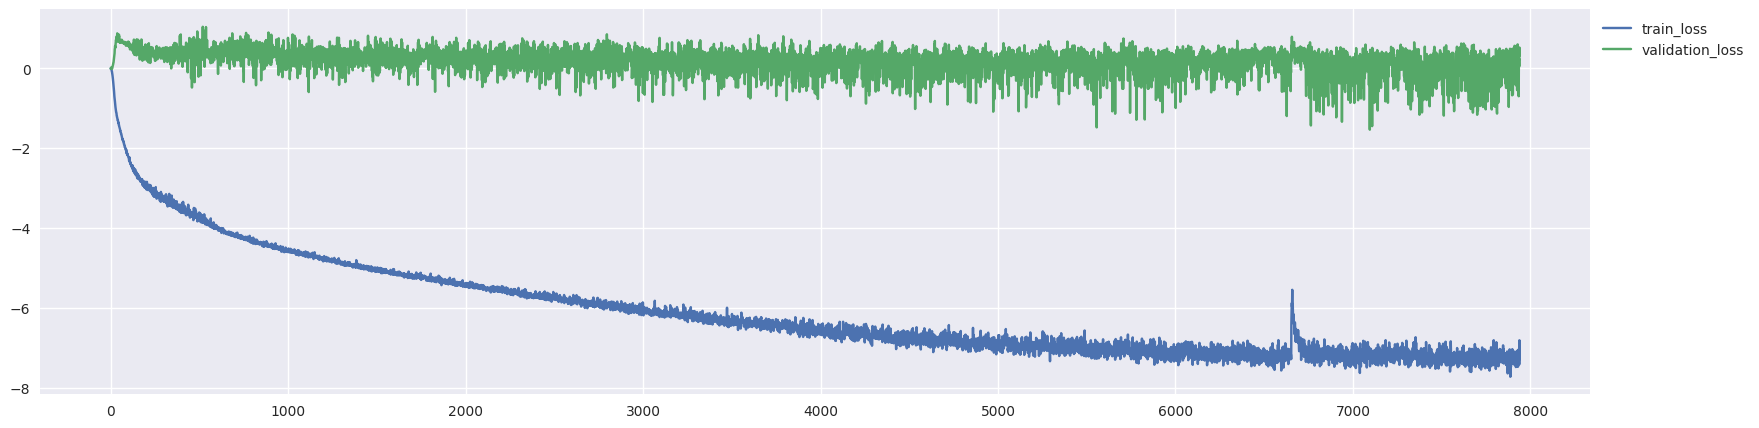

In [9]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

plt.figure(figsize=(20, 5))
x_ax = range(len(loss_save))
plt.plot(x_ax, np.log([loss[0] for loss in loss_save]), label="train_loss")
plt.plot(x_ax, np.log([loss[1] for loss in loss_save]), label="validation_loss")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


/tmp/ipykernel_7192/4054978383.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


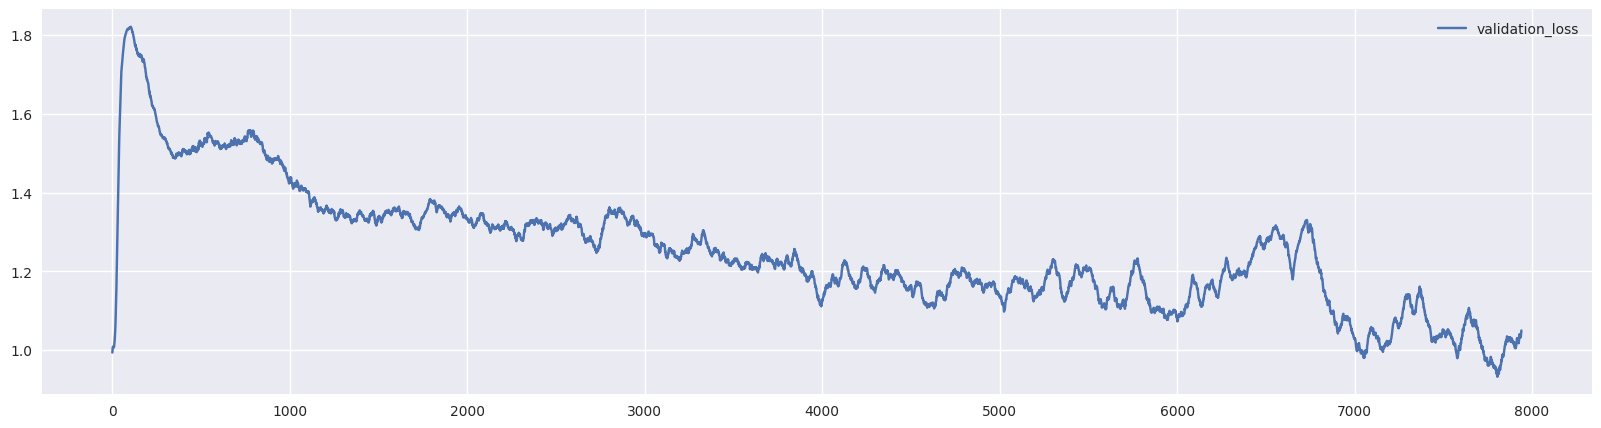

In [11]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

def tensorboard_smoothing(values, smooth=0.99):
    """
    values: List[`value` of Item]. You don't need to pass in `step`
    """
    # [0.81 0.9 1]. res[2] = (0.81 * values[0] + 0.9 * values[1] + values[2]) / 2.71
    norm_factor = 1
    x = 0
    res = []
    for i in range(len(values)):
        x = x * smooth + values[i]  # Exponential decay
        res.append(x / norm_factor)
        #
        norm_factor *= smooth
        norm_factor += 1
    return res

# values = [loss[1] for i, loss in enumerate(loss_save) if i % 10 == 0 and i != 0]
values = [loss[1] for i, loss in enumerate(loss_save)]
plt.figure(figsize=(20, 5))
x_ax = range(len(loss_save))
plt.plot(x_ax, tensorboard_smoothing(values), label="validation_loss")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


/tmp/ipykernel_7192/2677568074.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


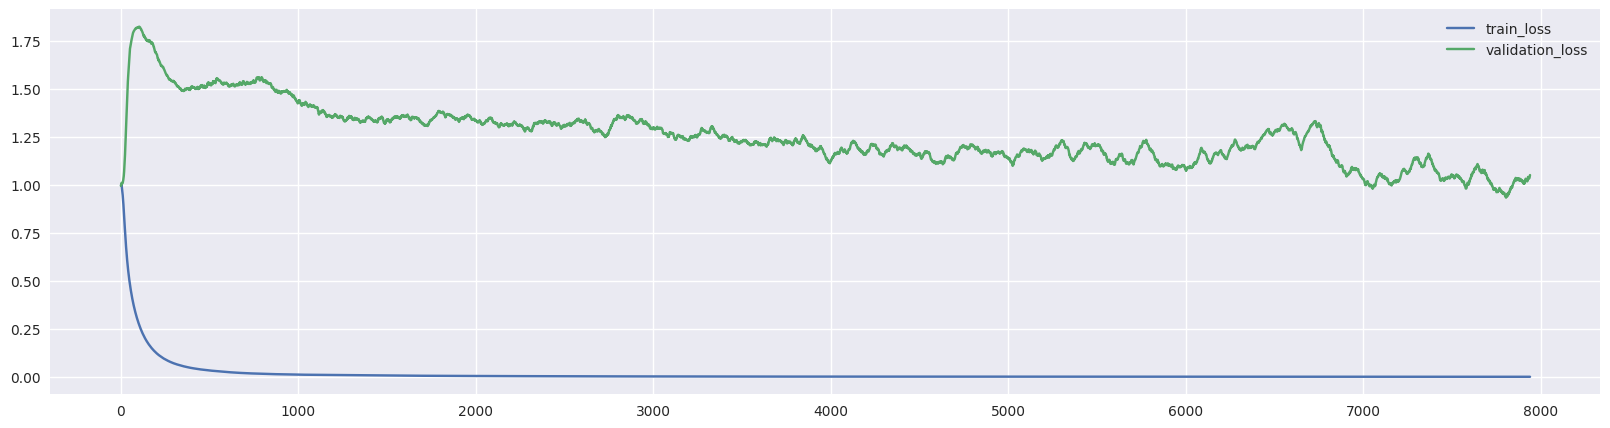

In [12]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

plt.figure(figsize=(20, 5))
x_ax = range(len(loss_save))
plt.plot(x_ax, tensorboard_smoothing([loss[0] for loss in loss_save]), label="train_loss")
plt.plot(x_ax, tensorboard_smoothing([loss[1] for loss in loss_save]), label="validation_loss")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


In [13]:
minn = 10000

for i, loss in enumerate(loss_save):
    if loss[1] < minn:
        print(i, loss[1])
        minn = loss[1]

0 0.994044303894043
434 0.9073085784912109
453 0.7808409333229065
458 0.6196911931037903
1116 0.5531976819038391
2530 0.5144184231758118
2646 0.5081875324249268
2975 0.4428679645061493
3053 0.4318421185016632
4256 0.4141632616519928
4533 0.3618912994861603
4973 0.3382318615913391
5556 0.22820033133029938
7095 0.21546302735805511


/tmp/ipykernel_567/2690886620.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


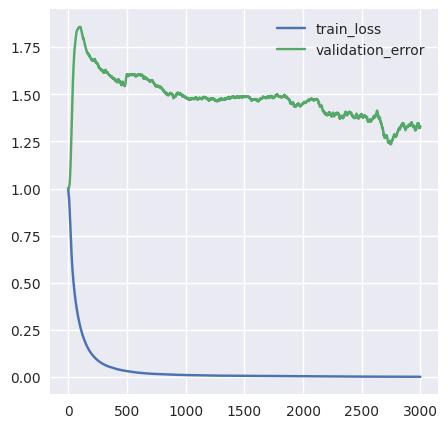

In [42]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

plt.figure(figsize=(5, 5))
x_ax = range(3000)
plt.plot(x_ax, tensorboard_smoothing([loss[0] for loss in loss_save[:3000]]), label="train_loss")
plt.plot(x_ax, tensorboard_smoothing([loss[1] for loss in loss_save[:3000]]), label="validation_error")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


# Forecasting - Find the best model

In [14]:
test_data.shape

(10961, 576, 4)

In [15]:
len(train_loader)

2647

In [ ]:
import os
from random import randint

# define the hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
n_cells = 576
n_indicators = 4
input_size = n_cells, n_indicators
hidden_size = 64
batch_size = 16
seq_len = 1000
num_layers = 2
cycle_len = 500


# define the autoregressive forecasting model
class LSTM(nn.Module):
    def __init__(self, num_input_features, hidden_layer_size, num_layers):
        super().__init__()
        input_size = num_input_features[0] * num_input_features[1]
        
        self.num_layer = num_layers
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_layer_size, input_size)
        self.hidden_cell = None

    def forward(self, x):
        batch_size, seq_len, height, width = x.size()
        x = x.view(batch_size, seq_len, height*width)
        lstm_out, self.hidden_cell = self.lstm(x, self.hidden_cell)
        preds = []
        for t in range(seq_len):
            pred = self.fc(lstm_out[:, t, :])
            pred = pred.view(batch_size, 1, height, width)
            preds.append(pred)
        
        return torch.cat(preds, axis=1)
    
model = LSTM(input_size, hidden_size, num_layers)
data_in = preprocess(test_data)

for ep in range(0, 3):
    for bi in range(0, 2400):
        path = f"lstm_minloss-{ep}-{bi}.pt"
        if os.path.isfile(path):
            print(path)

            model.load_state_dict(torch.load(path))
            model = model.to(device)

            # evaluate model:
            model.eval()

            # Test the model
            future = 4000
            warm_up = cycle_len
            node_id = randint(0, n_cells-1)
            # node_id = 100
            with torch.no_grad():
                inputs = torch.from_numpy(data_in).float().to(device)
                inputs = inputs.unsqueeze(0)

                preds = []
                st = 1000#randint(0, cycle_len)
                print("node_id", node_id, "start: ", st)
                inpt = inputs[:, st-warm_up-1: st-1, :, :]

                model.hidden_cell = (torch.zeros(num_layers, 1, model.hidden_layer_size).to(device),
                                torch.zeros(num_layers, 1, model.hidden_layer_size).to(device))
                pred_outputs = model(inpt)
                inpt = pred_outputs[:, -1, :, :].unsqueeze(1)

                for i in range(future):
                    output = model(inpt)
                    preds.append(output)
                    inpt = output
                preds = torch.cat(preds, axis=1)
                Vm = np.array(preds.cpu().detach().numpy())
                
                # 1
                plt.figure()
                plt.plot(range(future), Vm[0, :, node_id, 0], label=str(node_id))
                show_data = test_data[st+warm_up: st+warm_up+future, node_id, 0]
                plt.plot(range(show_data.shape[0]), show_data, label=f"true_{node_id}")
                plt.legend()
                plt.show()
                
                # 2
                plt.figure()
                plt.plot(range(future), Vm[0, :, node_id, 1], label=str(node_id))
                show_data = test_data[st+warm_up: st+warm_up+future, node_id, 1]
                plt.plot(range(show_data.shape[0]), show_data, label=f"true_{node_id}")
                plt.legend()
                plt.show()
                
                # 3
                plt.figure()
                plt.plot(range(future), Vm[0, :, node_id, 2], label=str(node_id))
                show_data = test_data[st+warm_up: st+warm_up+future, node_id, 2]
                plt.plot(range(show_data.shape[0]), show_data, label=f"true_{node_id}")
                plt.legend()
                plt.show()
                
                # 4
                plt.figure()
                plt.plot(range(future), Vm[0, :, node_id, 3], label=str(node_id))
                show_data = test_data[st+warm_up: st+warm_up+future, node_id, 3]
                plt.plot(range(show_data.shape[0]), show_data, label=f"true_{node_id}")
                plt.legend()
                plt.show()

            